In [27]:
import os
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Subset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, random_split
from torchinfo import summary

In [28]:
PROJECT_PATH = os.path.join(os.getcwd(), "throughput_estimator_mac_iq")
DATASET_PATH = os.path.join(PROJECT_PATH, 'dataset_gnb_10db_(interferer_ue)')
print(DATASET_PATH)
wgn_file_paths = glob.glob(os.path.join(DATASET_PATH, 'df_wgn_*.parquet'))
print(wgn_file_paths)

/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_mac_iq/dataset_gnb_10db_(interferer_ue)
['/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_mac_iq/dataset_gnb_10db_(interferer_ue)/df_wgn_2_de390cac8de345d997e8376a7e36eb5f_20_-12.2.parquet', '/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_mac_iq/dataset_gnb_10db_(interferer_ue)/df_wgn_0_31f73544dae74716ba3af75330d02301_5_-50.0.parquet', '/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_mac_iq/dataset_gnb_10db_(interferer_ue)/df_wgn_3_71cbc372fc174c1ea07389b2d30bd4a7_15_-7.6.parquet', '/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_mac_iq/dataset_gnb_10db_(interferer_ue)/df_wgn_2_de390cac8de345d997e8376a7e36eb5f_3_-22.0.parquet', '/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_mac_iq/dataset_gnb_10db_(interferer_ue)/df_wgn_2_de390cac8de345d997e8376a7e36eb5f_2_-23.0.parquet', '/opt/nvidia/cuBB/pyaerial/notebooks/throughput_estimator_mac_iq/dataset_gnb_10db_(interferer_ue)/df_wgn_2_de39

In [29]:
noise_levels = [float(wgn_file_path.replace('.parquet', '').split('_')[-1]) for wgn_file_path in wgn_file_paths]
noise_levels.sort()
print(noise_levels)

[-100.0, -90.0, -80.0, -70.0, -60.0, -50.0, -40.0, -39.0, -38.0, -37.0, -36.0, -35.0, -34.0, -33.0, -32.0, -31.0, -30.0, -29.0, -28.0, -27.0, -26.0, -25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18.0, -17.0, -16.0, -15.0, -14.0, -13.8, -13.6, -13.4, -13.2, -13.0, -12.8, -12.6, -12.4, -12.2, -12.0, -11.8, -11.6, -11.4, -11.2, -11.0, -10.8, -10.6, -10.4, -10.2, -10.0, -9.8, -9.6, -9.4, -9.2, -9.0, -8.8, -8.6, -8.4, -8.2, -8.0, -7.8, -7.6, -7.4, -7.2]


In [30]:
import heapq
def moving_average(arr, window_size):
    weights = np.ones(window_size) / window_size
    return np.convolve(arr, weights, mode='valid')

def get_throughput(arr):
    W = 10
    mv_avg = moving_average(arr, W)
    largest_numbers = heapq.nlargest(W, mv_avg)
    return sum(largest_numbers) / W

In [31]:
# Noise level
# -- target_throughput_mbps

dataset = pd.DataFrame()

for noise_level_idx, noise_level in enumerate(noise_levels):
    if noise_level_idx % 2 == 1:
        continue
    print(f'Noise level: {noise_level}')

    wgn_files = glob.glob(os.path.join(DATASET_PATH, f'df_wgn_*{noise_level}*.parquet'))
    if len(wgn_files) != 1:
        print(f'Found {len(wgn_files)} files for noise level {noise_level}')
        continue
    wgn_file_path = wgn_files[0]
    wgn_df = pd.read_parquet(wgn_file_path)
    # print(wgn_df)
    throughput_mbps = wgn_df['throughput_mbps'].values
    # print(throughput_mbps)
    # plt.plot(throughput_mbps)
    # plt.show()
    throughput = get_throughput(throughput_mbps)
    
    mac_files = glob.glob(os.path.join(DATASET_PATH, f'df_mac_*{noise_level}*.parquet'))
    if len(mac_files) != 1:
        print(f'Found {len(mac_files)} files for noise level {noise_level}')
        continue
    mac_file_path = mac_files[0]
    mac_df = pd.read_parquet(mac_file_path)
    # print(mac_df)

    fapi_files = glob.glob(os.path.join(DATASET_PATH, f'df_fapi_*{noise_level}*.parquet'))
    if len(fapi_files) != 1:
        print(f'Found {len(fapi_files)} files for noise level {noise_level}')
        continue
    fapi_file_path = fapi_files[0]
    fapi_df = pd.read_parquet(fapi_file_path)
    # print(fapi_df)
    
    fh_files = glob.glob(os.path.join(DATASET_PATH, f'df_fh_*{noise_level}*.parquet'))
    if len(fh_files) != 1:
        print(f'Found {len(fh_files)} files for noise level {noise_level}')
        continue
    fh_file_path = fh_files[0]
    fh_df = pd.read_parquet(fh_file_path)
    # print(fh_df)

    for fapi_idx, fapi in fapi_df.iterrows():
        TsTaiNs = fapi.TsTaiNs
        print(f'Sample at {TsTaiNs}')

        matching_mac = mac_df[mac_df['TsTaiNs'] <= TsTaiNs]
        # print(matching_mac)
        if len(matching_mac) < 30:
            continue

        # Sort by TsTaiNs in descending order and get the 10 latest records
        matching_mac = matching_mac.sort_values(by='TsTaiNs', ascending=False).head(30)
        # print(matching_mac)
        matching_mac = matching_mac[['ss_rsrp', 'ss_rsrq', 'ss_sinr', 'ri', 'wb_cqi_1tb', 'cri', 'phr', 'pusch_snr', 'ul_mcs1', 'ul_bler', 'ul_harq_0', 'ul_harq_1', 'ul_harq_2', 'ul_harq_3']].to_numpy()
        # print(matching_mac.shape) # (20, 14)
        # print(matching_mac)
        # Assuming matching_mac is the NumPy array with shape (n_samples, 14)
        # Columns: ['ss_rsrp', 'ss_rsrq', 'ss_sinr', 'ri', 'wb_cqi_1tb', 'cri', 'phr', 
        #           'pusch_snr', 'ul_mcs1', 'ul_bler', 'ul_harq_0', 'ul_harq_1', 'ul_harq_2', 'ul_harq_3']

        # Assuming matching_mac is the NumPy array with shape (n_samples, 14)
        # Columns: ['ss_rsrp', 'ss_rsrq', 'ss_sinr', 'ri', 'wb_cqi_1tb', 'cri', 'phr', 
        #           'pusch_snr', 'ul_mcs1', 'ul_bler', 'ul_harq_0', 'ul_harq_1', 'ul_harq_2', 'ul_harq_3']

        # Step 1: Compute HARQ differences (harq_new - harq_old)
        # harq_new is first row, harq_old is each subsequent row
        harq_indices = [10, 11, 12, 13]  # Indices of ul_harq_0 to ul_harq_3
        modified_matching_mac = matching_mac.copy()  # Avoid modifying original array

        # Compute differences: first row (harq_new) - current row (harq_old)
        for idx in harq_indices:
            modified_matching_mac[:, idx] = matching_mac[0, idx] - matching_mac[:, idx]
            # Handle uint32 wrap-around (if old > new, difference might be negative)
            modified_matching_mac[:, idx] = np.where(
                modified_matching_mac[:, idx] < 0,
                modified_matching_mac[:, idx] + 2**32,
                modified_matching_mac[:, idx]
            )
        # First row's HARQ differences set to 0 (no difference from itself)
        modified_matching_mac[0, harq_indices] = 0

        # Step 2: Define fixed min/max values for normalization
        fixed_max_values = np.array([
            -44,  # ss_rsrp (dBm)
            -3,   # ss_rsrq (dB)
            30,   # ss_sinr (dB)
            4,    # ri
            15,   # wb_cqi_1tb
            7,    # cri
            40,   # phr (dB)
            30,   # pusch_snr (dB)
            31,   # ul_mcs1
            1,    # ul_bler
            1000,  # ul_harq_0 (max difference in retransmissions, adjust as needed)
            1000,  # ul_harq_1
            1000,  # ul_harq_2
            1000   # ul_harq_3
        ])

        fixed_min_values = np.array([
            -140,  # ss_rsrp
            -20,   # ss_rsrq
            -20,   # ss_sinr
            1,     # ri
            0,     # wb_cqi_1tb
            0,     # cri
            -23,   # phr
            -20,   # pusch_snr
            0,     # ul_mcs1
            0,     # ul_bler
            0,     # ul_harq_0 (min difference)
            0,     # ul_harq_1
            0,     # ul_harq_2
            0      # ul_harq_3
        ])

        # Step 3: Min-Max normalization with fixed values
        range_vals = fixed_max_values - fixed_min_values
        range_vals[range_vals == 0] = 1  # Prevent division by zero

        normalized_matching_mac = (modified_matching_mac - fixed_min_values) / range_vals
        # print(normalized_matching_mac)

        matching_fh = fh_df[fh_df['TsTaiNs'] == TsTaiNs]
        # print(len(matching_fh))
        if len(matching_fh) != 1:
            continue
        # print(matching_fh)

        fh_samp = np.array(matching_fh['fhData'].iloc[0], dtype=np.float32)
        rx_slot = np.swapaxes(fh_samp.view(np.complex64).reshape(4, 14, 273*12), 2, 0)[:,:,0]
        # print(rx_slot)
        # print(rx_slot.shape)

        rx_slot[fapi.rbStart: fapi.rbSize * 12, fapi.StartSymbolIndex : 14] = 0
        I = np.real(rx_slot)  # Real part
        Q = np.imag(rx_slot)  # Imaginary part
        IQ_tensor = np.stack([I, Q], axis=0)
        # print(IQ_tensor.shape) # (2, 3276, 14)

        # # fig, axs = plt.subplots(1)
        # # axs.imshow(10*np.log10(np.abs(rx_slot**2)), aspect='auto')
        # # axs.set_ylim([0, 273 * 12])
        # # axs.set_xlim([0, 14])
        # # axs.set_title('Ant ' + str(0))
        # # axs.set(xlabel='Symbol', ylabel='Resource Element')
        # # axs.label_outer()
        # # fig.suptitle('Power in RU Antennas') 
        # # plt.show(fig)
        
        matching_wgn = wgn_df[wgn_df['timestamp'] <= TsTaiNs]
        matching_wgn = matching_wgn.sort_values(by='timestamp', ascending=False).head(1)
        # print(matching_wgn['target_throughput_mbps'].to_numpy()[0])
        target_throughput_mbps = matching_wgn['target_throughput_mbps'].to_numpy()[0]
        normalization_target_throughput_mbps = target_throughput_mbps

        new_row = pd.DataFrame({
            'noise_level': [noise_level],
            'target_throughput_mbps': [normalization_target_throughput_mbps],
            'max_throughput_mbps': [throughput],
            'mac': [normalized_matching_mac],
            'fapi': [[fapi.rbStart/273, fapi.rbSize/273, fapi.StartSymbolIndex/14, 14/14]],
            'iq': [IQ_tensor],
        })
        dataset = pd.concat([dataset, new_row], ignore_index=True)
    #     break
    # break


Noise level: -100.0
Sample at 2025-04-14 06:28:13.062000
Sample at 2025-04-14 06:28:14.002000
Sample at 2025-04-14 06:28:15.052000
Sample at 2025-04-14 06:28:16.042000
Sample at 2025-04-14 06:28:17.062000
Sample at 2025-04-14 06:28:18.022000
Sample at 2025-04-14 06:28:19.082000
Sample at 2025-04-14 06:28:20.022000
Sample at 2025-04-14 06:28:21.092000
Sample at 2025-04-14 06:28:22.082000
Sample at 2025-04-14 06:28:23.142000
Sample at 2025-04-14 06:28:24.002000
Sample at 2025-04-14 06:28:25.022000
Sample at 2025-04-14 06:28:26.042000
Sample at 2025-04-14 06:28:27.062000
Sample at 2025-04-14 06:28:28.012000
Sample at 2025-04-14 06:28:29.002000
Sample at 2025-04-14 06:28:30.022000
Sample at 2025-04-14 06:28:31.042000
Sample at 2025-04-14 06:28:32.062000
Sample at 2025-04-14 06:28:33.062000
Sample at 2025-04-14 06:28:34.032000
Sample at 2025-04-14 06:28:35.122000
Sample at 2025-04-14 06:28:36.042000
Sample at 2025-04-14 06:28:37.062000
Sample at 2025-04-14 06:28:38.082000
Sample at 2025-04-

       noise_level  target_throughput_mbps  max_throughput_mbps  \
0           -100.0                       0            53.673190   
1           -100.0                       0            53.673190   
2           -100.0                       0            53.673190   
3           -100.0                       0            53.673190   
4           -100.0                       0            53.673190   
...            ...                     ...                  ...   
14608         -7.2                       1             0.892886   
14609         -7.2                       1             0.892886   
14610         -7.2                       1             0.892886   
14611         -7.2                       1             0.892886   
14612         -7.2                       1             0.892886   

                                                     mac  \
0      [[0.6458333333333334, 0.5588235294117647, 0.87...   
1      [[0.6458333333333334, 0.5588235294117647, 0.87...   
2      [[0.6458

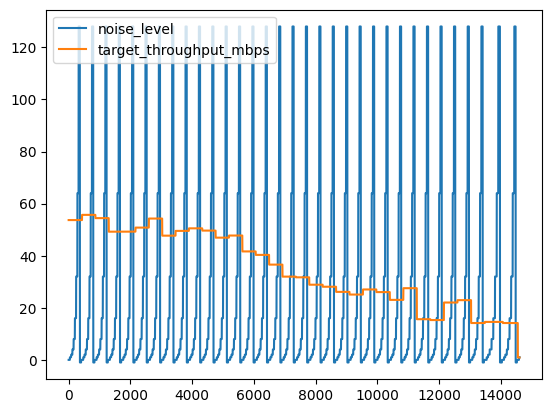

In [32]:
print(dataset)
# rbsize_s = np.stack(dataset['fapi'].to_numpy())[:, 1]
# print([rbsize if rbsize > 0.5 else 0 for rbsize in rbsize_s])
# print(np.stack(dataset['fapi'].to_numpy())[:, 1])
# plt.plot(np.stack(dataset['fapi'].to_numpy())[:, 1])
# plt.show()
noise_level_s = np.stack(dataset['noise_level'].to_numpy())
target_throughput_mbps_s = np.stack(dataset['target_throughput_mbps'].to_numpy())
max_throughput_mbps_s = np.stack(dataset['max_throughput_mbps'].to_numpy())
plt.plot(target_throughput_mbps_s)
# plt.plot(noise_level_s)
plt.plot(max_throughput_mbps_s)
plt.legend(['noise_level', 'target_throughput_mbps', 'max_throughput_mbps'])
plt.show()

In [66]:
%pip install xgboost

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


x shape: (14613, 14)
y shape: (14613,)


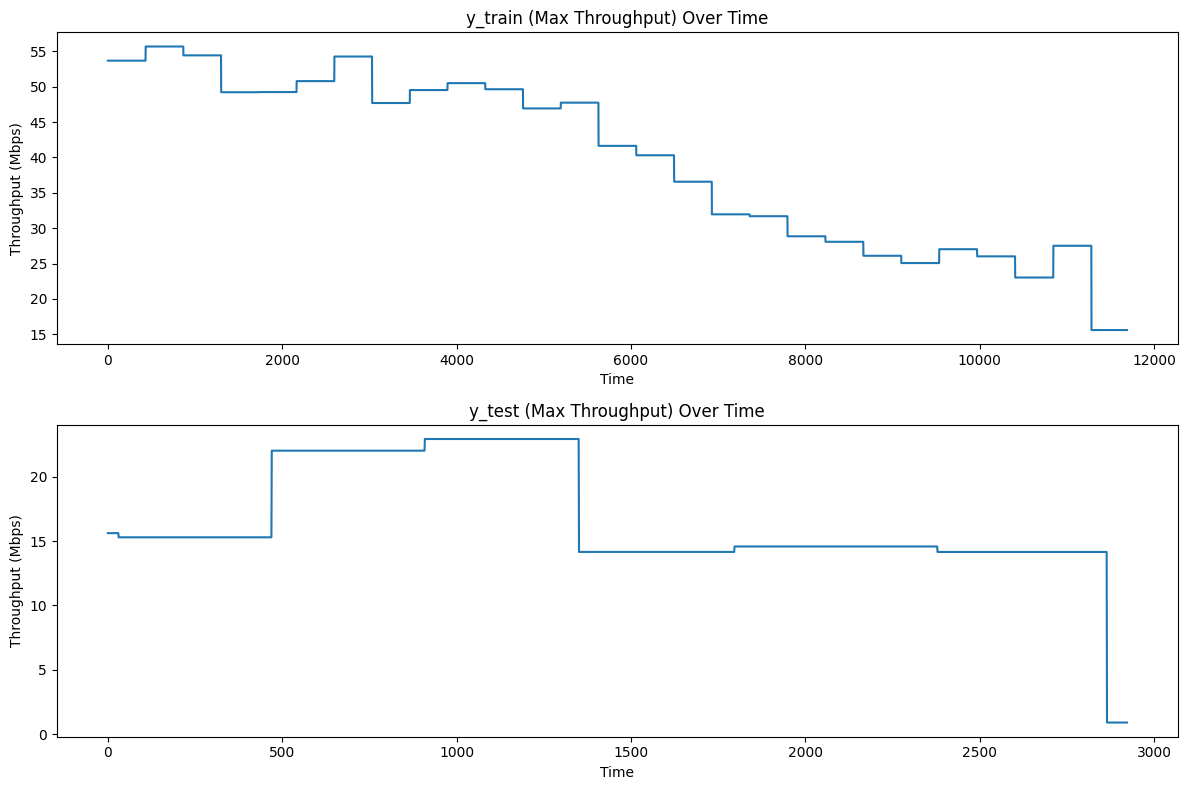

In [67]:
# Prepare data
x = np.stack(dataset['mac'].to_numpy())[:, -1, :]
y = np.stack(dataset['max_throughput_mbps'].to_numpy())
print("x shape:", x.shape)
print("y shape:", y.shape)

# Split data into train and test sets with random split but preserving test set order
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=False, random_state=1)

# Reshape data for XGBoost
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Plot y_train and y_test over time
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(y_train)
plt.title('y_train (Max Throughput) Over Time')
plt.xlabel('Time')
plt.ylabel('Throughput (Mbps)')

plt.subplot(2, 1, 2)
plt.plot(y_test)
plt.title('y_test (Max Throughput) Over Time')
plt.xlabel('Time')
plt.ylabel('Throughput (Mbps)')

plt.tight_layout()
plt.show()

In [33]:
# | (dataset['target_throughput_mbps'] == -1)
# selective_dataset = dataset[(dataset['target_throughput_mbps'] > 0.5) ]
selective_dataset = dataset

print("--- X ---")
# X_mac_torch = torch.tensor(np.stack(selective_dataset['mac'].to_numpy())[:,:,[8]], dtype=torch.float32)
X_mac_torch = torch.tensor(np.stack(selective_dataset['mac'].to_numpy()), dtype=torch.float32)
print(f'X_mac_torch.shape: {X_mac_torch.shape}')
X_fapi_torch = torch.tensor(np.stack(selective_dataset['fapi'].to_numpy()), dtype=torch.float32)
print(f'X_fapi_torch.shape: {X_fapi_torch.shape}')
X_iq_torch = torch.tensor(np.stack(selective_dataset['iq'].to_numpy()), dtype=torch.float32)
print(f'X_iq_torch.shape: {X_iq_torch.shape}')

print("--- Y ---")
Y_noise_level_torch = torch.tensor(selective_dataset['noise_level'].to_numpy(), dtype=torch.float32)
print(f'Y_noise_level_torch.shape: {Y_noise_level_torch.shape}')
Y_target_throughput_mbps_torch = torch.tensor(selective_dataset['target_throughput_mbps'].to_numpy(), dtype=torch.float32)
print(f'Y_target_throughput_mbps_torch.shape: {Y_target_throughput_mbps_torch.shape}')
Y_max_throughput_mbps_torch = torch.tensor(selective_dataset['max_throughput_mbps'].to_numpy(), dtype=torch.float32)
print(f'Y_max_throughput_mbps_torch.shape: {Y_max_throughput_mbps_torch.shape}')

--- X ---
X_mac_torch.shape: torch.Size([14613, 30, 14])
X_fapi_torch.shape: torch.Size([14613, 4])
X_iq_torch.shape: torch.Size([14613, 2, 3276, 14])
--- Y ---
Y_noise_level_torch.shape: torch.Size([14613])
Y_target_throughput_mbps_torch.shape: torch.Size([14613])
Y_max_throughput_mbps_torch.shape: torch.Size([14613])


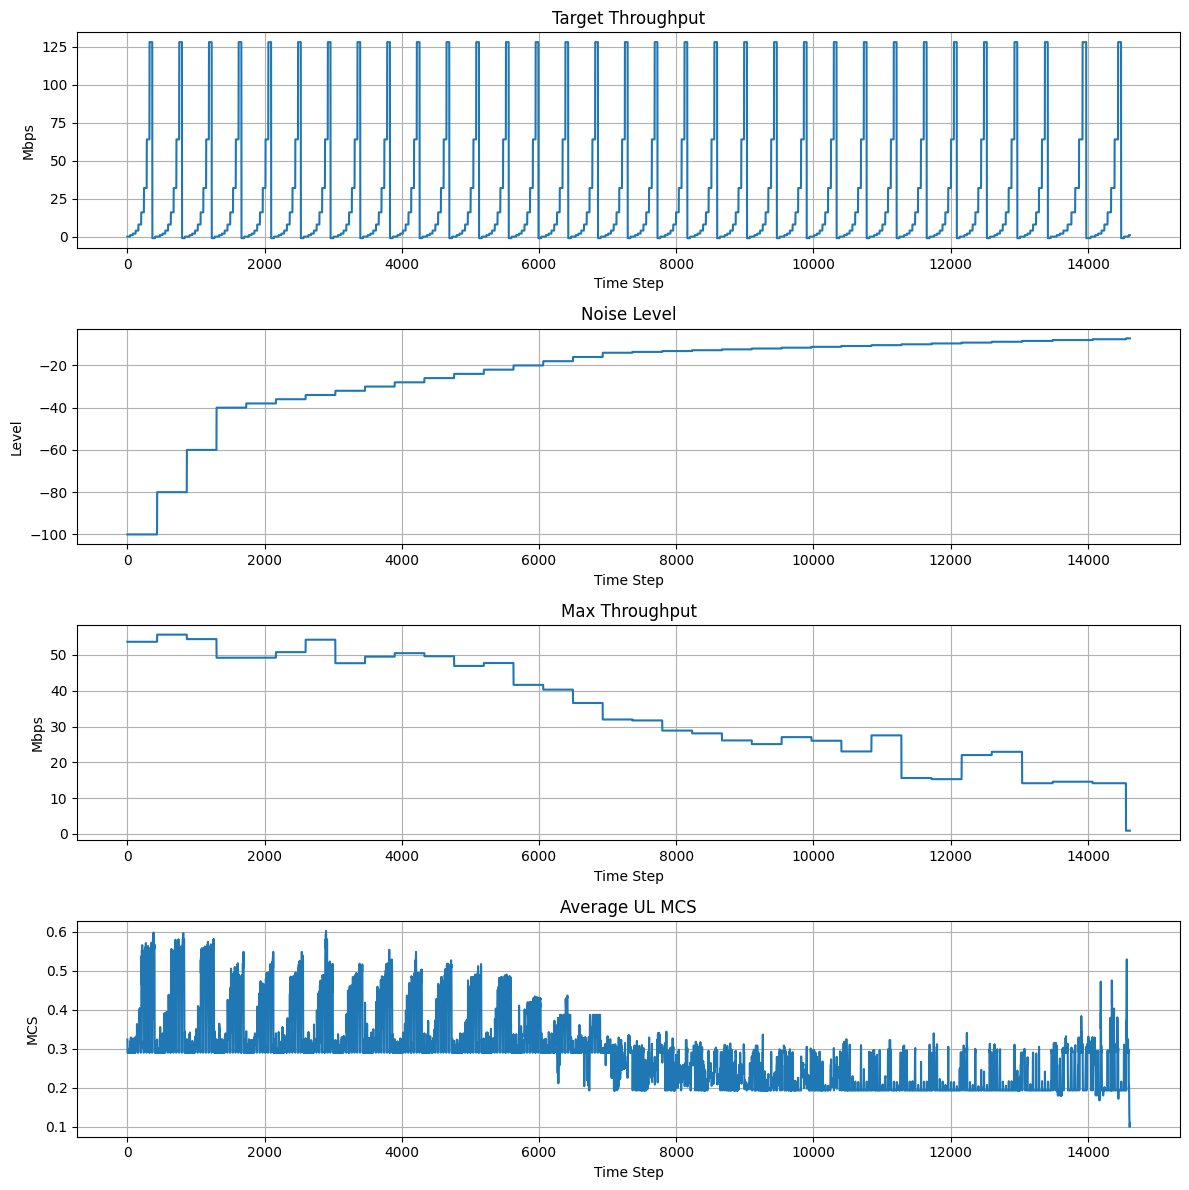

In [34]:
# rbsize_s = np.stack(dataset['fapi'].to_numpy())[:, 1]
# print([rbsize if rbsize > 0.5 else 0 for rbsize in rbsize_s])
# print(np.stack(dataset['fapi'].to_numpy())[:, 1])
# plt.plot(np.stack(dataset['fapi'].to_numpy())[:, 1])
# plt.show()
noise_level_s = np.stack(selective_dataset['noise_level'].to_numpy())
target_throughput_mbps_s = np.stack(selective_dataset['target_throughput_mbps'].to_numpy())
max_throughput_mbps_s = np.stack(selective_dataset['max_throughput_mbps'].to_numpy())
average_ul_mcs = np.average(np.stack(selective_dataset['mac'])[:,:,8], axis=1)


fig, axs = plt.subplots(4, 1, figsize=(12, 12))

# Plot 1: Target Throughput
axs[0].plot(target_throughput_mbps_s)
axs[0].set_title('Target Throughput')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Mbps')
axs[0].grid(True)

# Plot 2: Noise Level
axs[1].plot(noise_level_s)
axs[1].set_title('Noise Level')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Level')
axs[1].grid(True)

# Plot 3: Max Throughput
axs[2].plot(max_throughput_mbps_s)
axs[2].set_title('Max Throughput')
axs[2].set_xlabel('Time Step')
axs[2].set_ylabel('Mbps')
axs[2].grid(True)

# Plot 4: Average UL MCS
axs[3].plot(average_ul_mcs)
axs[3].set_title('Average UL MCS')
axs[3].set_xlabel('Time Step')
axs[3].set_ylabel('MCS')
axs[3].grid(True)

plt.tight_layout()
plt.show()

In [35]:
import torch
from torch.utils.data import TensorDataset, Subset, DataLoader

# Set fixed seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Create TensorDataset
tdataset = TensorDataset(X_mac_torch, X_fapi_torch, X_iq_torch, Y_noise_level_torch, Y_target_throughput_mbps_torch, Y_max_throughput_mbps_torch)

# Size setup
dataset_size = len(tdataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Generate a random permutation of indices
indices = torch.randperm(dataset_size).tolist()

# Split indices into train and test
train_indices = sorted(indices[:train_size])  # Take first train_size indices and sort
test_indices = sorted(indices[train_size:])   # Take remaining indices and sort

# Create Subsets
train_dataset = Subset(tdataset, train_indices)
test_dataset = Subset(tdataset, test_indices)

In [36]:
test_data = DataLoader(
    test_dataset,
    batch_size=1,      # 1024
    shuffle=False,     # No shuffling for evaluation
    drop_last=False
)
preloaded_test_data = list(test_data)

In [80]:
# Extract data from train_dataset and test_dataset
X_train = []
y_train = []
X_test = []
y_test = []

# Extract training data
for i in range(len(train_dataset)):
    mac_data, fapi_data, iq_data, noise_level, target_throughput, max_throughput = train_dataset[i]
    X_train.append(mac_data.numpy())
    y_train.append(max_throughput.numpy())

# Extract test data
for i in range(len(test_dataset)):
    mac_data, fapi_data, iq_data, noise_level, target_throughput, max_throughput = test_dataset[i]
    X_test.append(mac_data.numpy())
    y_test.append(max_throughput.numpy())

# Convert to numpy arrays
X_train = np.array(X_train)[:,-1,:]
y_train = np.array(y_train)
X_test = np.array(X_test)[:,-1,:]
y_test = np.array(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11690, 14)
(11690,)
(2923, 14)
(2923,)


In [101]:
# Create DMatrix for XGBoost with feature names
feature_names = ['ss_rsrp', 'ss_rsrq', 'ss_sinr', 'ri', 'wb_cqi_1tb', 'cri', 'phr', 
                'pusch_snr', 'ul_mcs1', 'ul_bler', 'ul_harq_0', 'ul_harq_1', 
                'ul_harq_2', 'ul_harq_3']
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

# Set XGBoost parameters
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'max_depth': 6,
#     'eta': 0.1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8
# }

params = {
    'objective': 'reg:squarederror',  # Regression with squared error (MSE)
    'n_estimators': 100,             # Number of boosting rounds
    'max_depth': 19,                 # Maximum tree depth
    'reg_alpha': 1.2,                # L1 regularization
    'reg_lambda': 1.2,               # L2 regularization
    'subsample': 0.8,                # Fraction of samples per tree
    'min_child_weight': 3,           # Minimum sum of instance weight
    'colsample_bytree': 0.9,         # Fraction of features per tree
    'learning_rate': 0.1,            # Step size shrinkage (eta)
    'random_state': 42,              # For reproducibility
    'n_jobs': -1                     # Use all CPU cores
}

# Train the model with early stopping
num_rounds = 200
evals = [(dtrain, 'train'), (dtest, 'test')]
xgb_model = xgb.train(params, dtrain, num_rounds, evals=evals, early_stopping_rounds=10, verbose_eval=False)

# Make predictions
y_pred = xgb_model.predict(dtest)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"XGBoost Model Results:")
print(f"R2 Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")


/home/aerial/.local/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [12:46:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


XGBoost Model Results:
R2 Score: 0.80
MAE: 3.62
MSE: 38.73


Complete Importance (including zero scores): {'ss_rsrp': 198.0, 'ss_rsrq': 1.0, 'ss_sinr': 0.0, 'ri': 0.0, 'wb_cqi_1tb': 109.0, 'cri': 0.0, 'phr': 1366.0, 'pusch_snr': 4553.0, 'ul_mcs1': 1210.0, 'ul_bler': 10241.0, 'ul_harq_0': 6249.0, 'ul_harq_1': 2347.0, 'ul_harq_2': 778.0, 'ul_harq_3': 353.0}
Number of features: 14


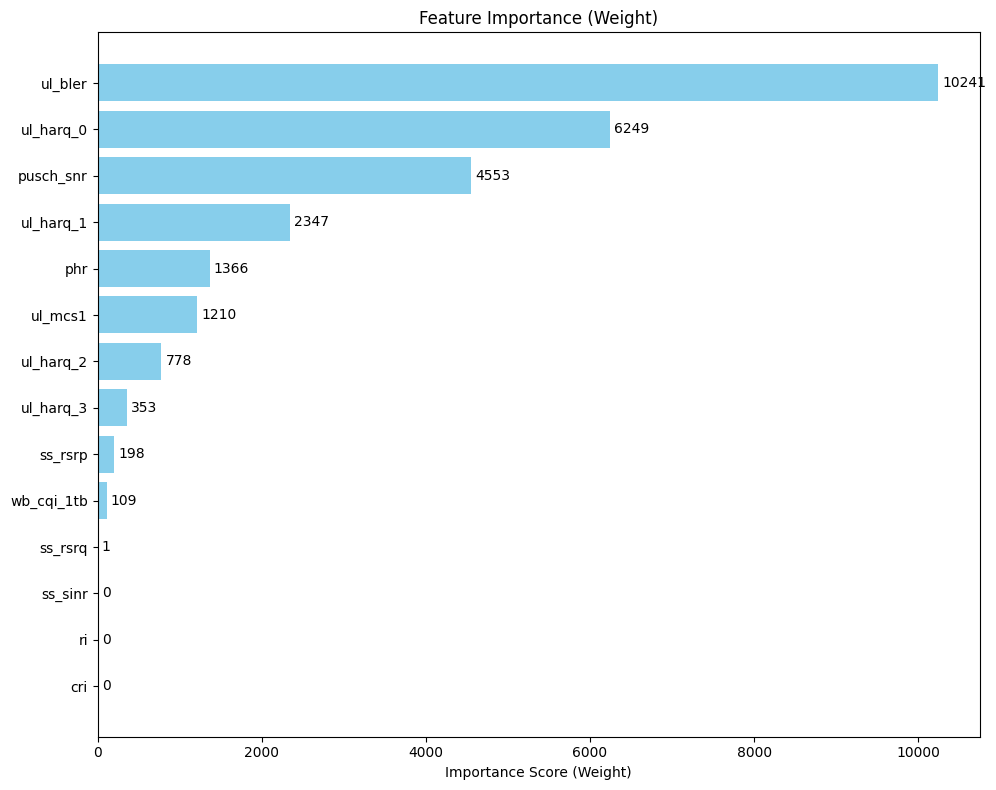

Complete Gain-based Importance: {'ss_rsrp': 1346.4315185546875, 'ss_rsrq': 1.8083148002624512, 'ss_sinr': 0.0, 'ri': 0.0, 'wb_cqi_1tb': 1123.438232421875, 'cri': 0.0, 'phr': 356.0213317871094, 'pusch_snr': 141.57254028320312, 'ul_mcs1': 3385.11474609375, 'ul_bler': 200.73928833007812, 'ul_harq_0': 152.4241180419922, 'ul_harq_1': 33.00508499145508, 'ul_harq_2': 292.20855712890625, 'ul_harq_3': 536.6819458007812}


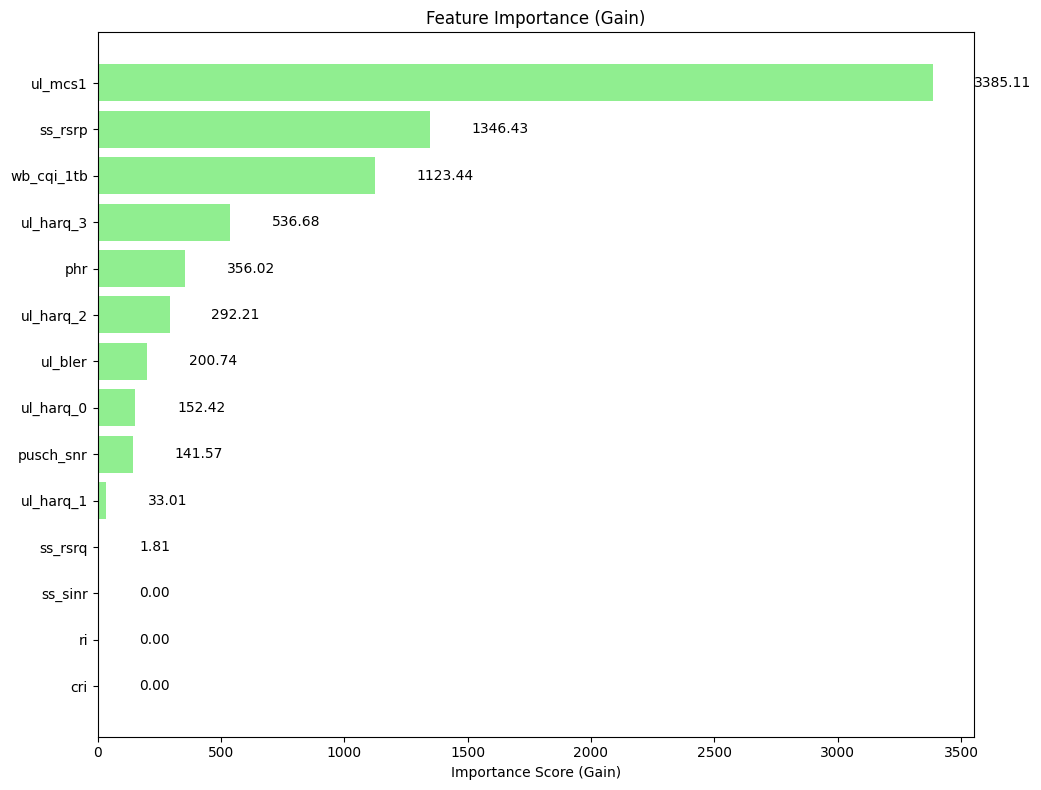

In [102]:
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd

# Define all feature names
feature_names = ['ss_rsrp', 'ss_rsrq', 'ss_sinr', 'ri', 'wb_cqi_1tb', 'cri', 'phr', 
                 'pusch_snr', 'ul_mcs1', 'ul_bler', 'ul_harq_0', 'ul_harq_1', 
                 'ul_harq_2', 'ul_harq_3']

# Get feature importance scores (weight)
importance = xgb_model.get_score(importance_type='weight')

# Create a complete importance dictionary with all features
complete_importance = {feat: importance.get(feat, 0.0) for feat in feature_names}
print("Complete Importance (including zero scores):", complete_importance)

# Sort features by importance (descending), include all 14
sorted_importance = sorted(complete_importance.items(), key=lambda x: x[1], reverse=True)
print("Number of features:", len(sorted_importance))

# Convert to DataFrame for plotting
importance_df = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])

# Plot feature importance (weight) with values at the end of bars
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df['Feature'][::-1], importance_df['Importance'][::-1], color='skyblue')
plt.xlabel('Importance Score (Weight)')
plt.title('Feature Importance (Weight)')
plt.tight_layout()

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 50, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
             ha='left', va='center', fontsize=10)

plt.show()

# Get gain-based importance
importance_gain = xgb_model.get_score(importance_type='gain')
complete_importance_gain = {feat: importance_gain.get(feat, 0.0) for feat in feature_names}
print("Complete Gain-based Importance:", complete_importance_gain)

# Sort and convert to DataFrame
sorted_importance_gain = sorted(complete_importance_gain.items(), key=lambda x: x[1], reverse=True)
importance_gain_df = pd.DataFrame(sorted_importance_gain, columns=['Feature', 'Importance'])

# Plot feature importance (gain) with values at the end of bars
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_gain_df['Feature'][::-1], importance_gain_df['Importance'][::-1], color='lightgreen')
plt.xlabel('Importance Score (Gain)')
plt.title('Feature Importance (Gain)')
plt.tight_layout()

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    max_gain = max(importance_gain_df['Importance'])
    offset = 0.05 * max_gain if max_gain > 0 else 0.1  # Avoid division by zero
    plt.text(width + offset, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
             ha='left', va='center', fontsize=10)

plt.show()

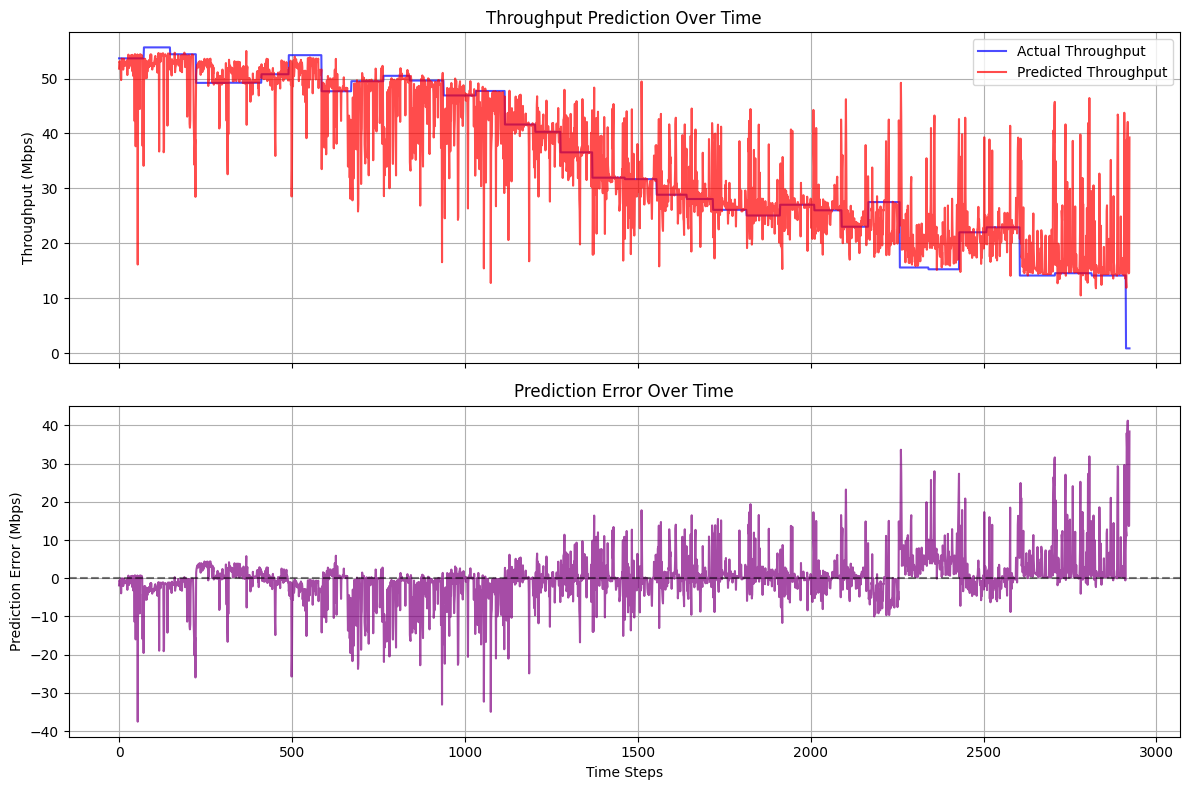

In [103]:
# Create a more detailed time series plot with additional context
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot 1: Throughput comparison
ax1.plot(y_test, label='Actual Throughput', color='blue', alpha=0.7)
ax1.plot(y_pred, label='Predicted Throughput', color='red', alpha=0.7)
ax1.set_ylabel('Throughput (Mbps)')
ax1.set_title('Throughput Prediction Over Time')
ax1.legend()
ax1.grid(True)

# Plot 2: Prediction error
error = y_pred - y_test
ax2.plot(error, color='purple', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Prediction Error (Mbps)')
ax2.set_title('Prediction Error Over Time')
ax2.grid(True)

plt.tight_layout()
plt.show()

Layer (type:depth-idx)                   Param #
ThroughputEstimatorMacIq                 --
├─LSTM: 1-1                              46,400
├─Sequential: 1-2                        --
│    └─Conv2d: 2-1                       304
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       4,640
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       7,862,500
│    └─ReLU: 2-9                         --
│    └─Dropout: 2-10                     --
├─Sequential: 1-3                        --
│    └─Linear: 2-11                      5,050
│    └─ReLU: 2-12                        --
│    └─Dropout: 2-13                     --
│    └─Linear: 2-14                      51
Total params: 7,918,945
Trainable params: 7,918,945
Non-trainable params: 0
Models moved to device successfully.
Parameter 'lstm.weight_ih_l0

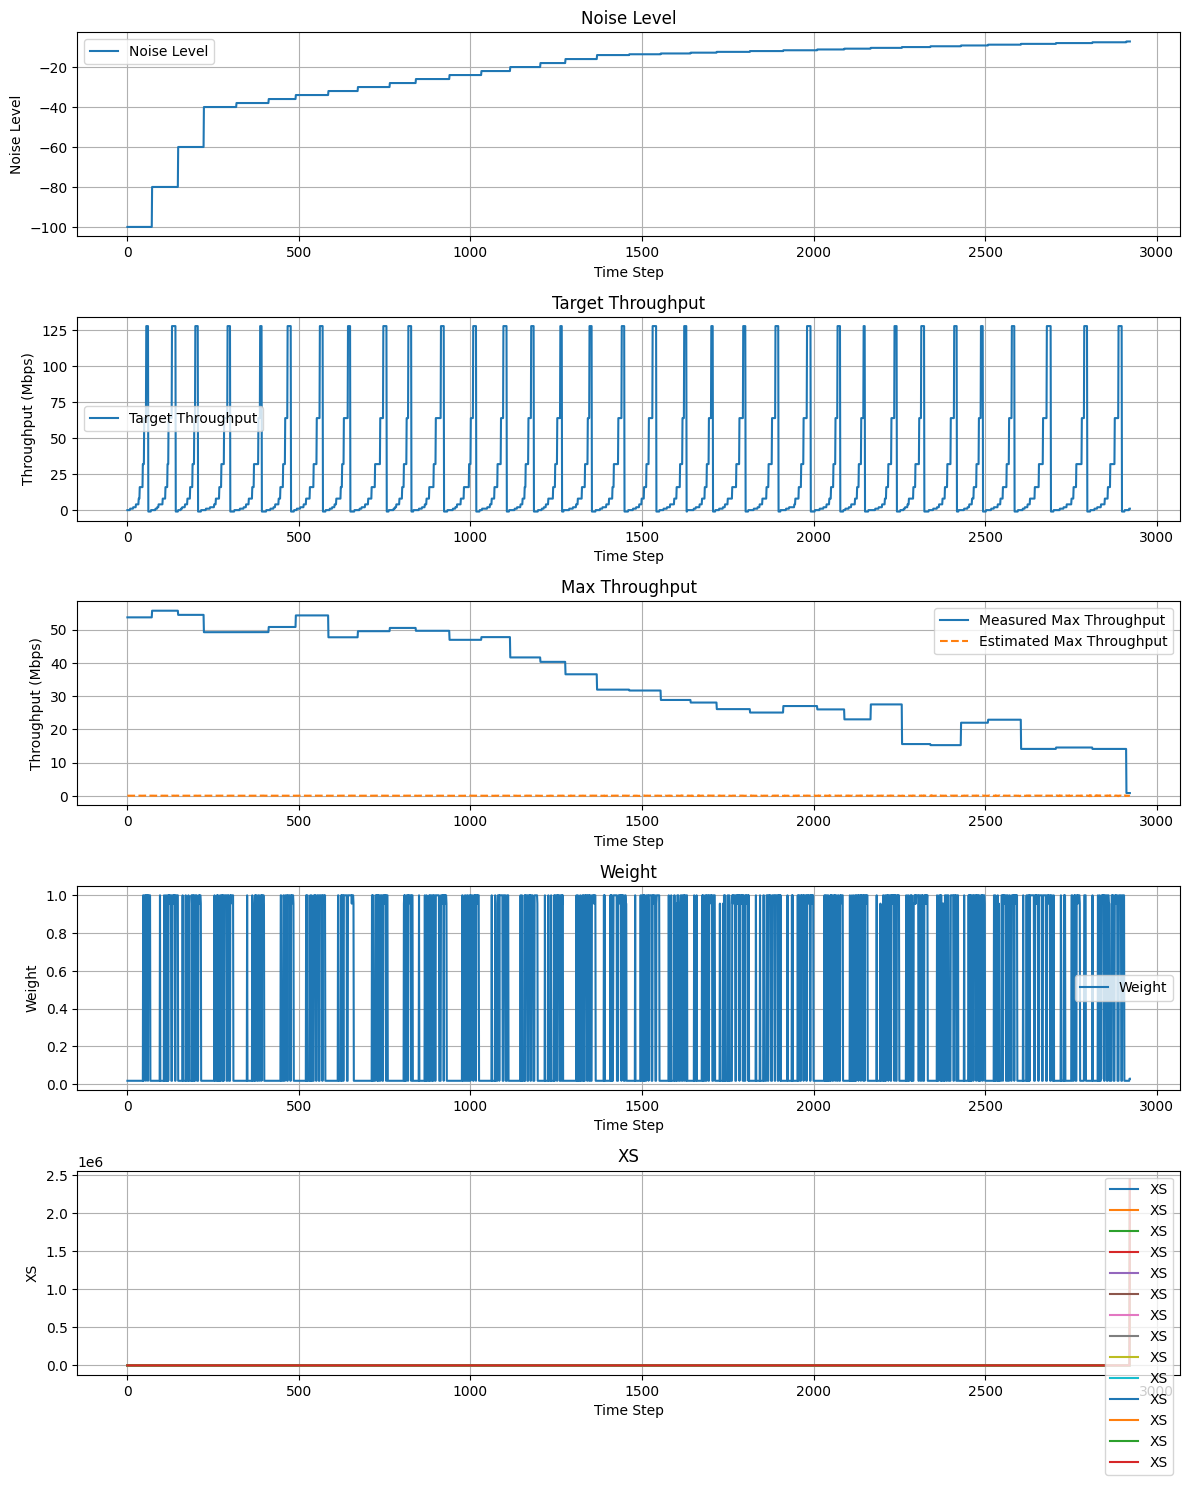

Layer (type:depth-idx)                   Param #
ThroughputEstimatorMac                   --
├─LSTM: 1-1                              46,400
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       5,050
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       51
Total params: 51,501
Trainable params: 51,501
Non-trainable params: 0
Models moved to device successfully.
Parameter 'lstm.weight_ih_l0' is on device: cuda:0
Parameter 'lstm.weight_hh_l0' is on device: cuda:0
Parameter 'lstm.bias_ih_l0' is on device: cuda:0
Parameter 'lstm.bias_hh_l0' is on device: cuda:0
Parameter 'fc.0.weight' is on device: cuda:0
Parameter 'fc.0.bias' is on device: cuda:0
Parameter 'fc.3.weight' is on device: cuda:0
Parameter 'fc.3.bias' is on device: cuda:0
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.018

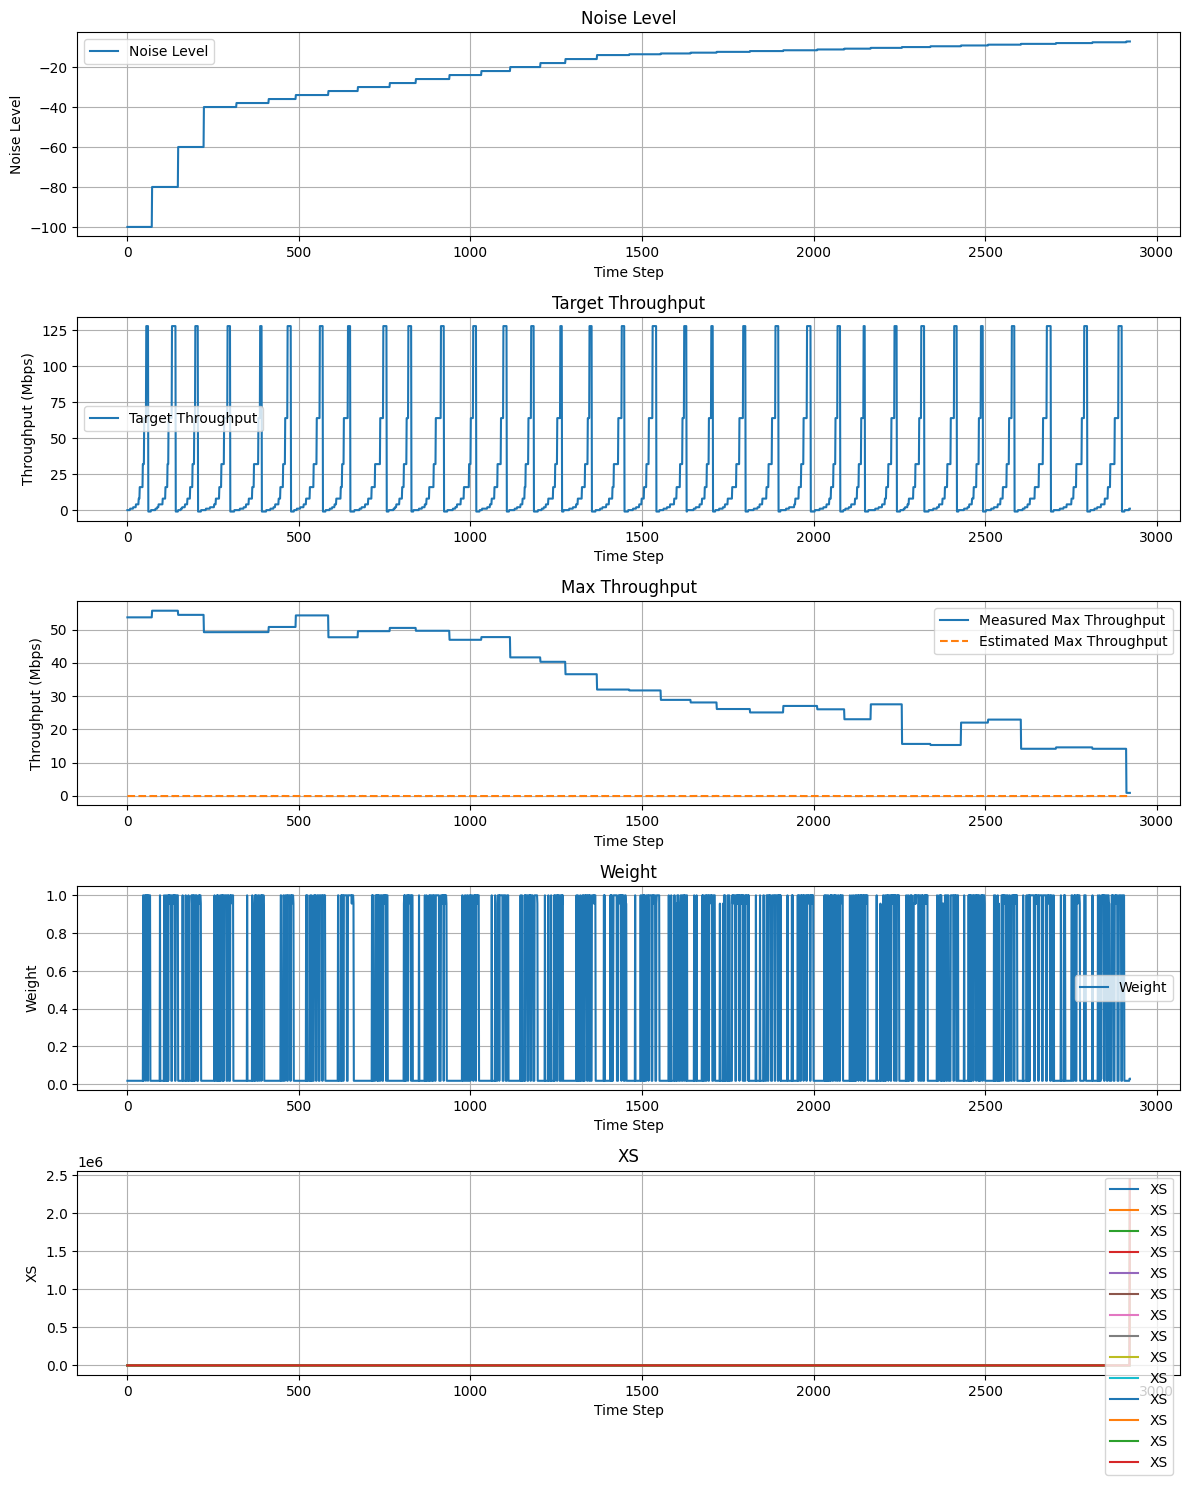

Layer (type:depth-idx)                   Param #
ThroughputEstimatorIq                    --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       304
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       4,640
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Flatten: 2-7                      --
│    └─Linear: 2-8                       7,862,500
│    └─ReLU: 2-9                         --
│    └─Dropout: 2-10                     --
├─Sequential: 1-2                        --
│    └─Linear: 2-11                      5,050
│    └─ReLU: 2-12                        --
│    └─Dropout: 2-13                     --
│    └─Linear: 2-14                      51
Total params: 7,872,545
Trainable params: 7,872,545
Non-trainable params: 0
Models moved to device successfully.
Parameter 'cnn.0.weight' is on device: cuda:0
Parameter 'cnn.0.bias' is on d

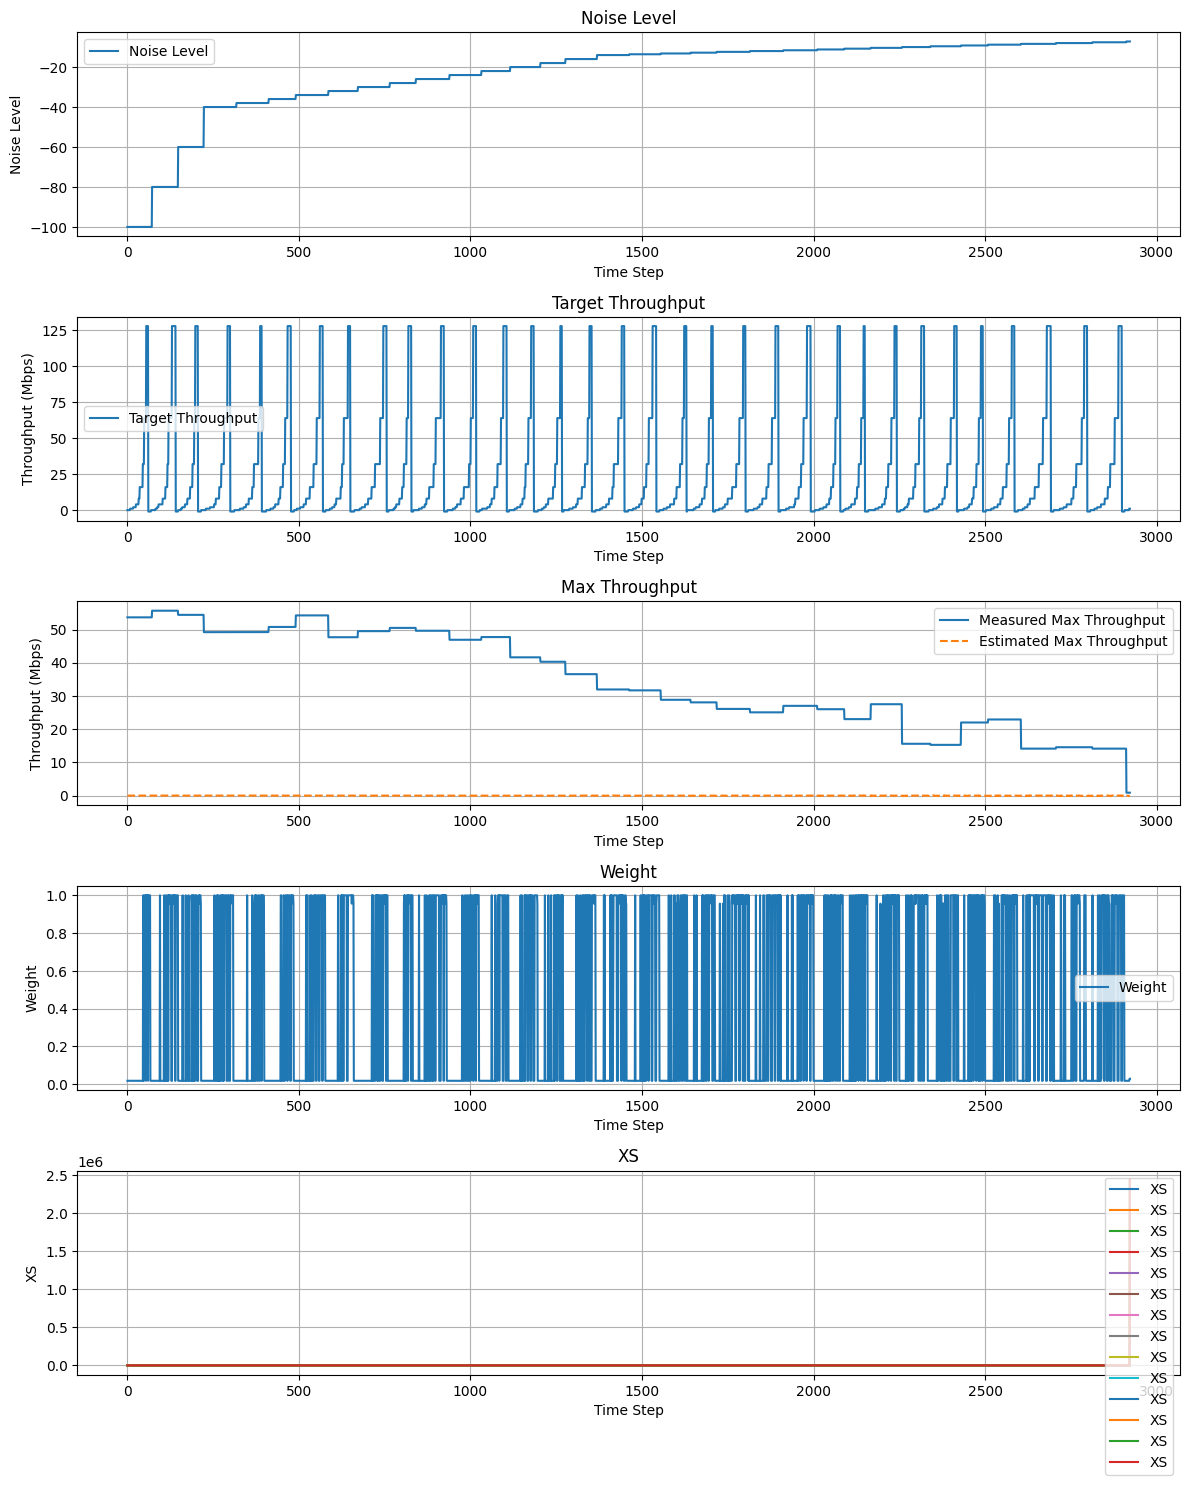

In [11]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(PROJECT_PATH)

import importlib
import throughput_estimator_model
importlib.reload(throughput_estimator_model)
from throughput_estimator_model import *

mac_iq_model = ThroughputEstimatorMacIq(14, 1, 100, 1)
mac_iq_model.show_summary()
mac_iq_model.to_device()
mac_iq_model.show_test(preloaded_test_data)

mac_model = ThroughputEstimatorMac(14, 1, 100, 1)
mac_model.show_summary()
mac_model.to_device()
mac_model.show_test(preloaded_test_data)

iq_model = ThroughputEstimatorIq(14, 1, 100, 1)
iq_model.show_summary()
iq_model.to_device()
iq_model.show_test(preloaded_test_data)

In [12]:
# Create DataLoaders
train_data = DataLoader(
    train_dataset,
    batch_size=2**5,  # 1024
    shuffle=True,      # Shuffle training data each epoch
    drop_last=False
)
preloaded_train_data = list(train_data)

In [13]:
# Initialize criterion and optimizers
criterion = nn.MSELoss()
mac_iq_optimizer = torch.optim.Adam(mac_iq_model.parameters(), lr=0.001, weight_decay=0.005)
mac_optimizer = torch.optim.Adam(mac_model.parameters(), lr=0.001, weight_decay=0.005)
iq_optimizer = torch.optim.Adam(iq_model.parameters(), lr=0.001, weight_decay=0.005)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    # Initialize losses
    mac_iq_train_loss = 0
    mac_train_loss = 0
    iq_train_loss = 0

    # Set models to training mode
    mac_iq_model.train()
    mac_model.train()
    iq_model.train()

    for i, (batch_mac, batch_fapi, batch_iq, batch_y_noise_level, batch_y_target_throughput_mbps, batch_y_max_throughput_mbps) in enumerate(preloaded_train_data):
        # Move data to device
        batch_mac = batch_mac.to(0)
        batch_fapi = batch_fapi.to(0)
        batch_iq = batch_iq.to(0)
        batch_y_max_throughput_mbps = batch_y_max_throughput_mbps.to(0)

        # Train MAC-IQ model
        mac_iq_optimizer.zero_grad()
        mac_iq_outputs, _ = mac_iq_model(batch_mac, batch_fapi, batch_iq)
        mac_iq_loss = criterion(mac_iq_outputs, batch_y_max_throughput_mbps)
        mac_iq_loss.backward()
        mac_iq_optimizer.step()
        mac_iq_train_loss += mac_iq_loss.item() * batch_y_max_throughput_mbps.size(0)

        # Train MAC model
        mac_optimizer.zero_grad()
        mac_outputs, _ = mac_model(batch_mac, batch_fapi, batch_iq)
        mac_loss = criterion(mac_outputs, batch_y_max_throughput_mbps)
        mac_loss.backward()
        mac_optimizer.step()
        mac_train_loss += mac_loss.item() * batch_y_max_throughput_mbps.size(0)

        # Train IQ model
        iq_optimizer.zero_grad()
        iq_outputs, _ = iq_model(batch_mac, batch_fapi, batch_iq)
        iq_loss = criterion(iq_outputs, batch_y_max_throughput_mbps)
        iq_loss.backward()
        iq_optimizer.step()
        iq_train_loss += iq_loss.item() * batch_y_max_throughput_mbps.size(0)

    # Calculate average losses
    mac_iq_train_loss = mac_iq_train_loss / len(train_dataset)
    mac_train_loss = mac_train_loss / len(train_dataset)
    iq_train_loss = iq_train_loss / len(train_dataset)

    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'MAC-IQ train_loss: {mac_iq_train_loss}')
    print(f'MAC train_loss: {mac_train_loss}')
    print(f'IQ train_loss: {iq_train_loss}')
    print('---')

Epoch [1/100]
MAC-IQ train_loss: 188.39644408017983
MAC train_loss: 357.78254770192456
IQ train_loss: 139.13651536300307
---
Epoch [2/100]
MAC-IQ train_loss: 67.11131580114568
MAC train_loss: 201.97886225143185
IQ train_loss: 91.6713650483979
---
Epoch [3/100]
MAC-IQ train_loss: 26.07058199106678
MAC train_loss: 139.64421019933488
IQ train_loss: 89.19419741340944
---
Epoch [4/100]
MAC-IQ train_loss: 19.131052189509617
MAC train_loss: 100.22470081025867
IQ train_loss: 86.52004176874871
---
Epoch [5/100]
MAC-IQ train_loss: 16.8856823263666
MAC train_loss: 95.59436415124898
IQ train_loss: 85.6724218415847
---
Epoch [6/100]
MAC-IQ train_loss: 17.29671605830523
MAC train_loss: 90.32285356741873
IQ train_loss: 82.71273774864125
---
Epoch [7/100]
MAC-IQ train_loss: 17.589808394706992
MAC train_loss: 88.45671331635697
IQ train_loss: 81.65752449655655
---
Epoch [8/100]
MAC-IQ train_loss: 17.974565005649147
MAC train_loss: 86.21155297219805
IQ train_loss: 80.99176143714767
---
Epoch [9/100]
MAC-

---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: t

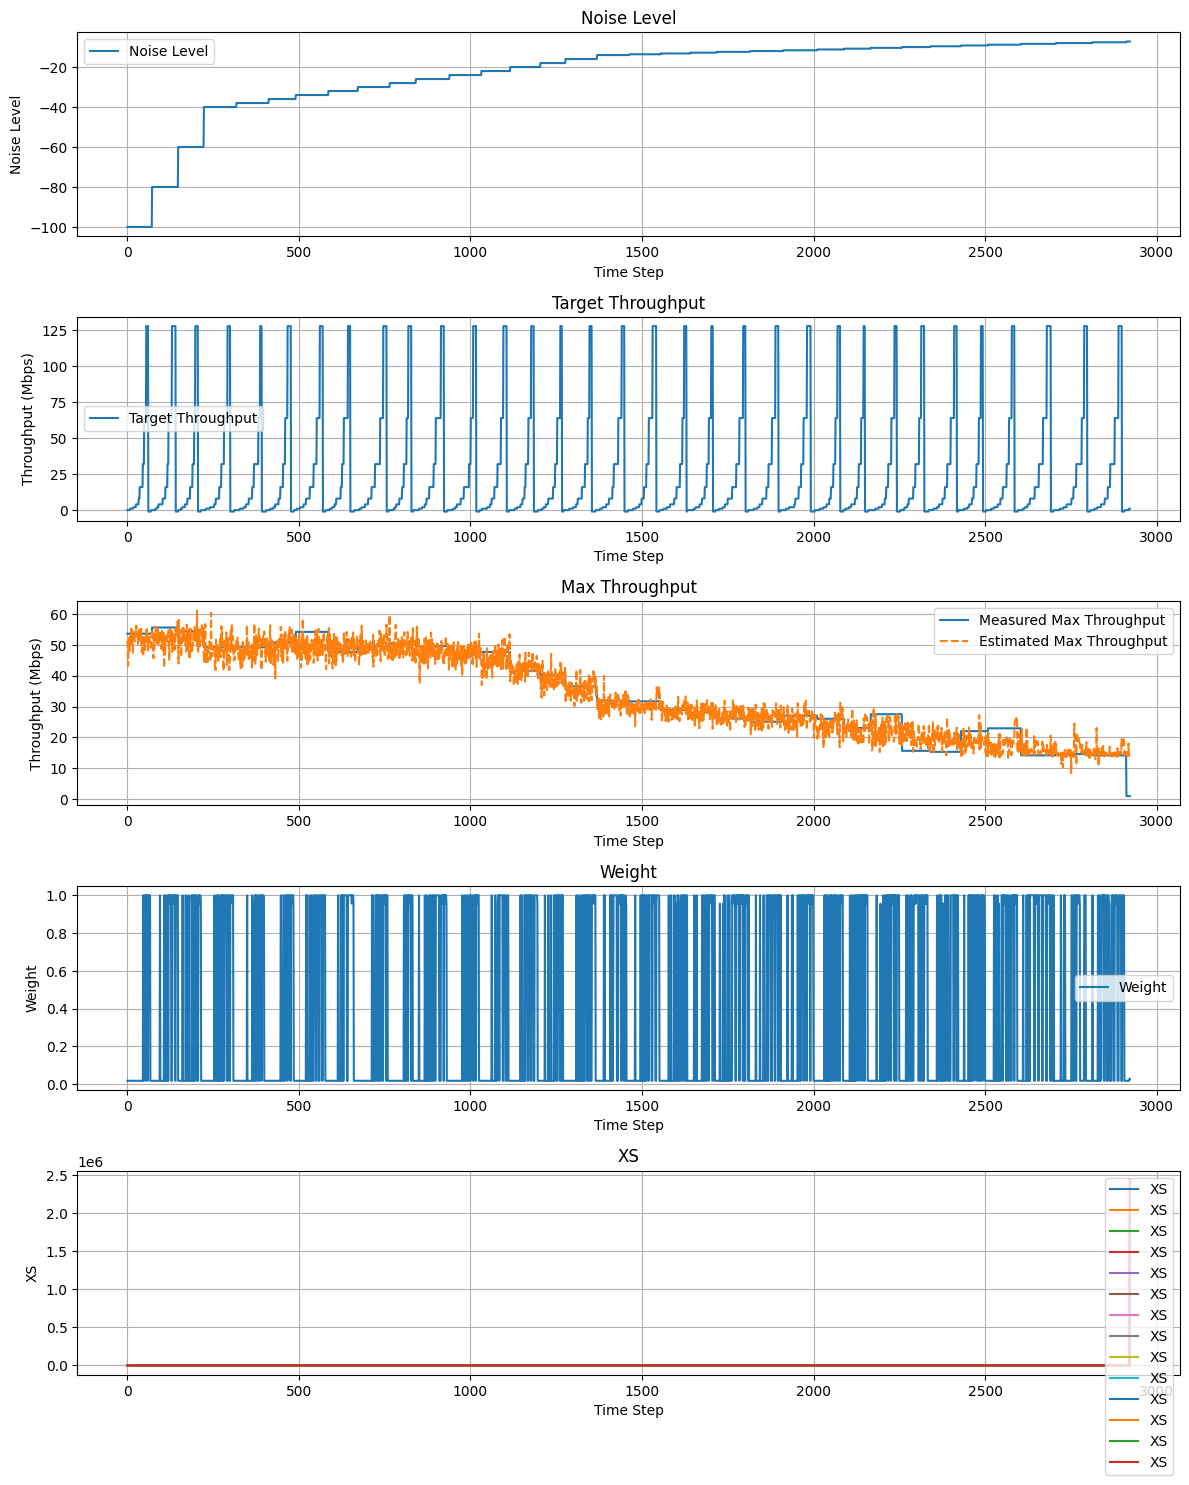

---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: t

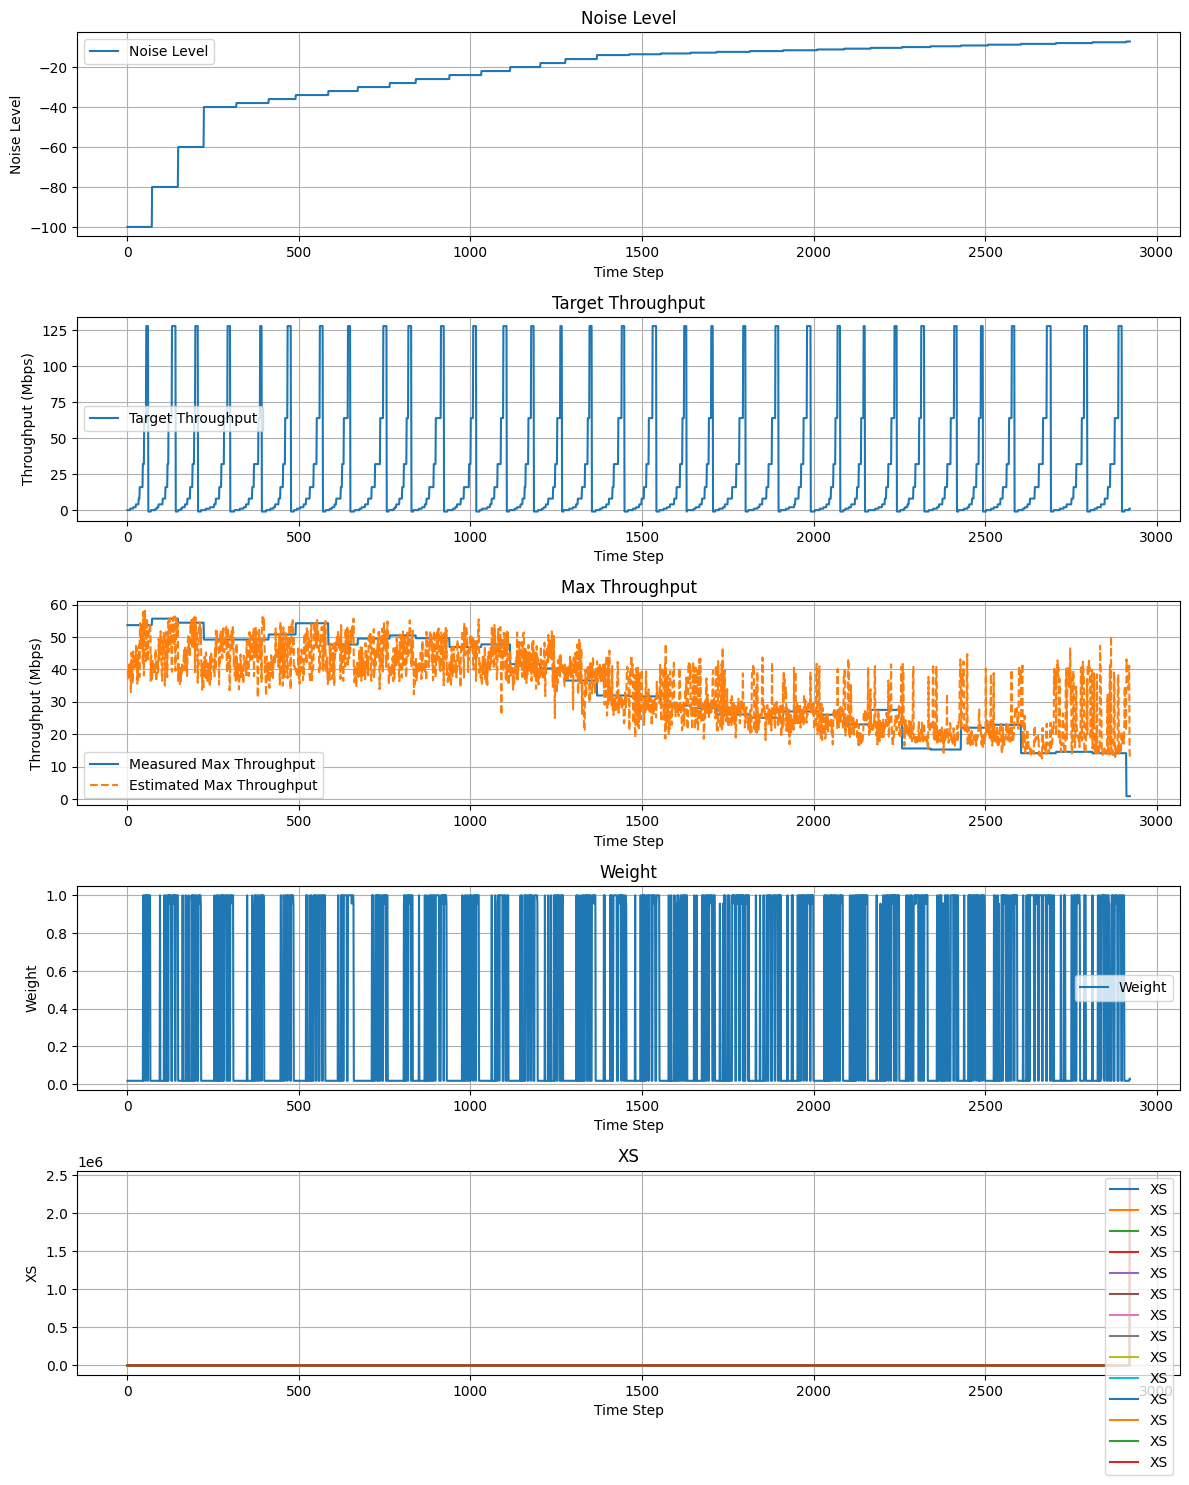

---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: t

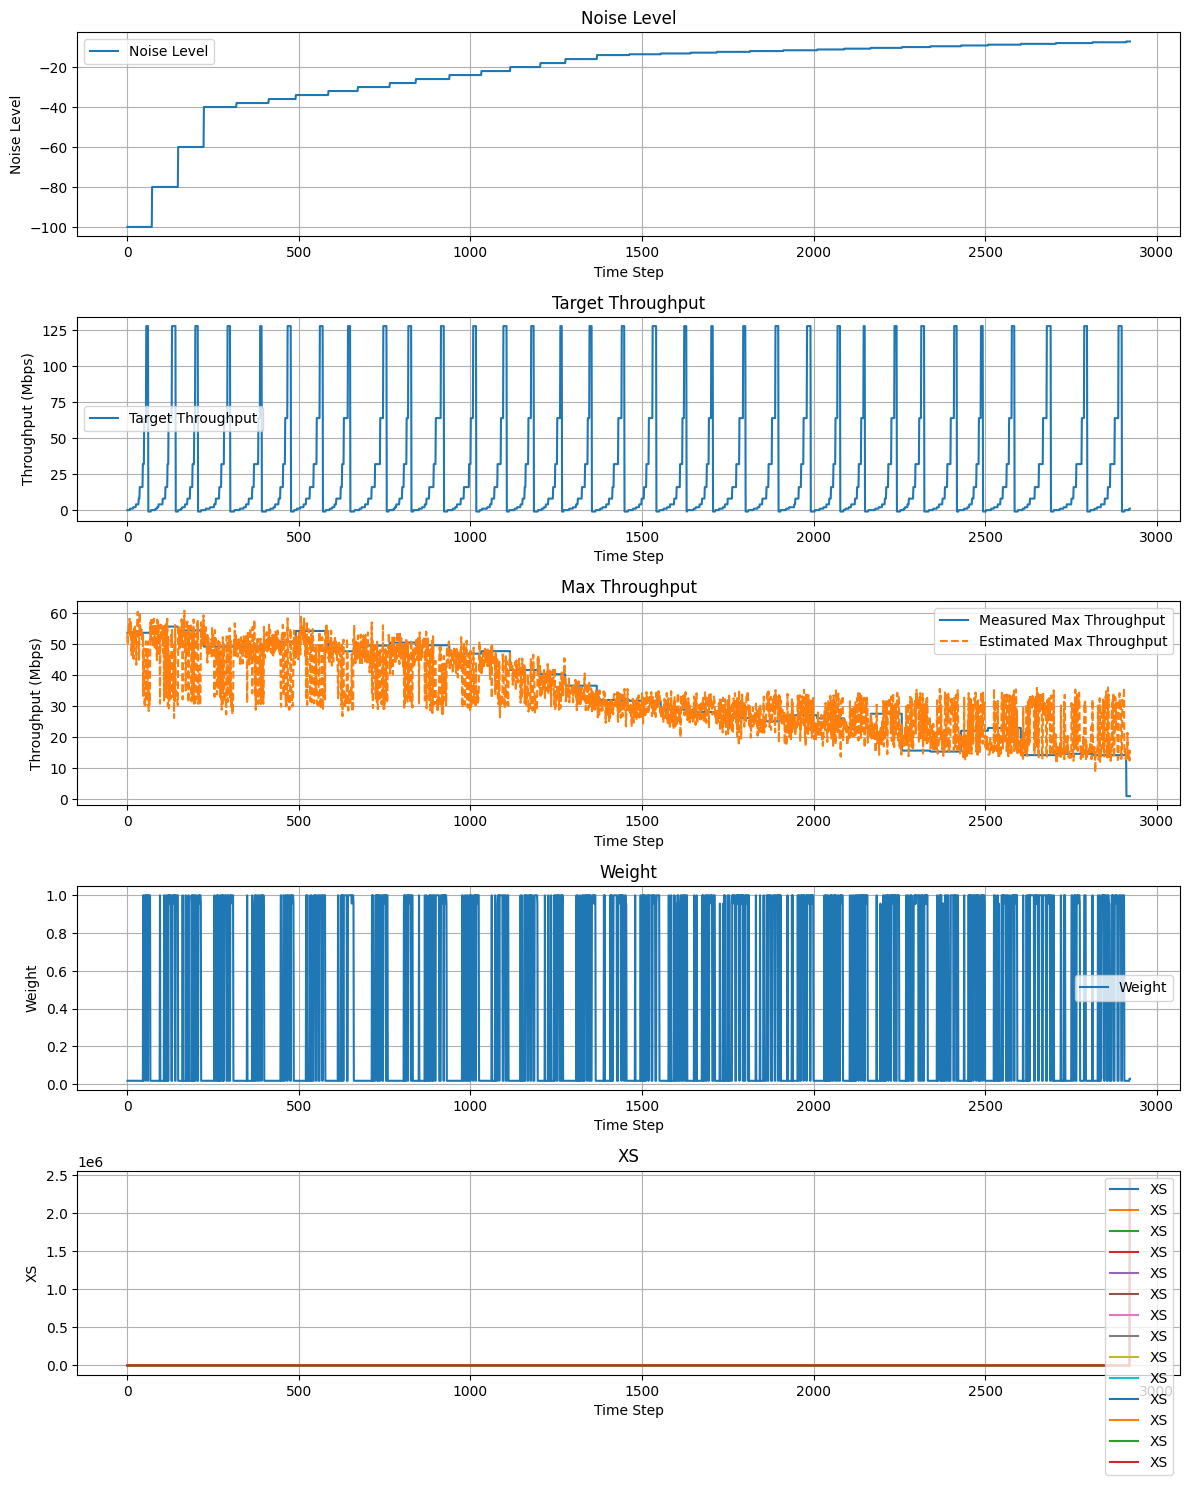

---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: t

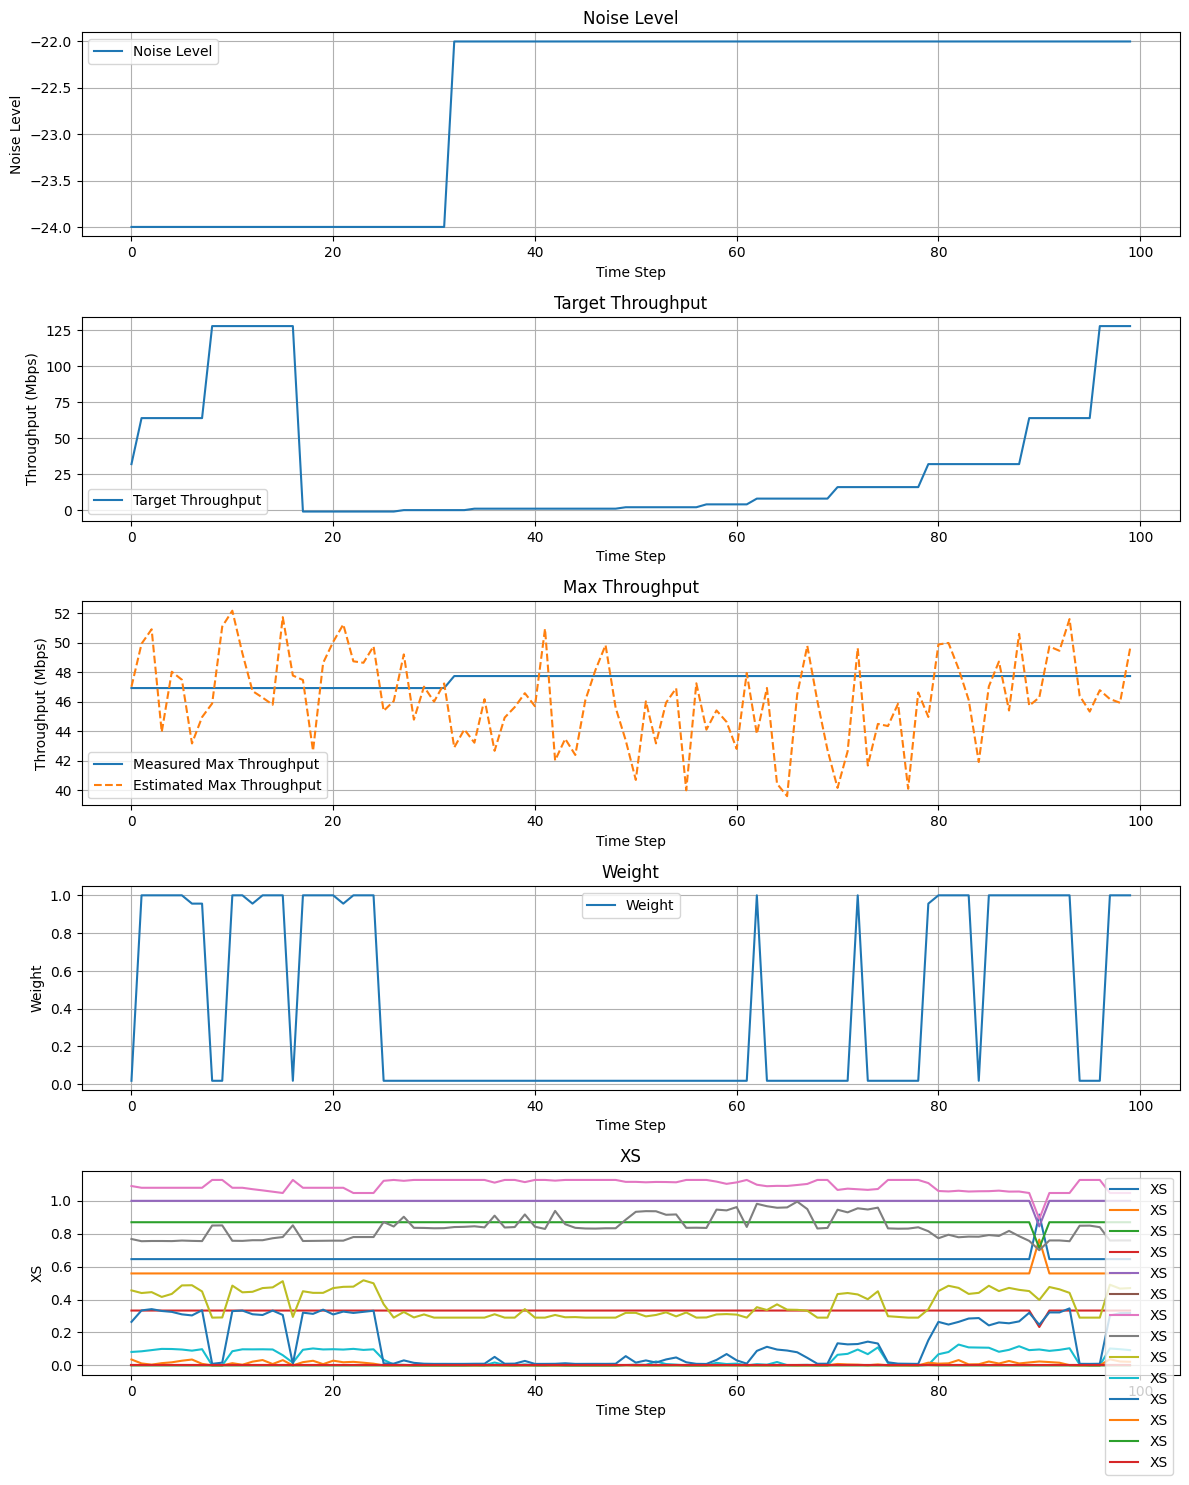

---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: t

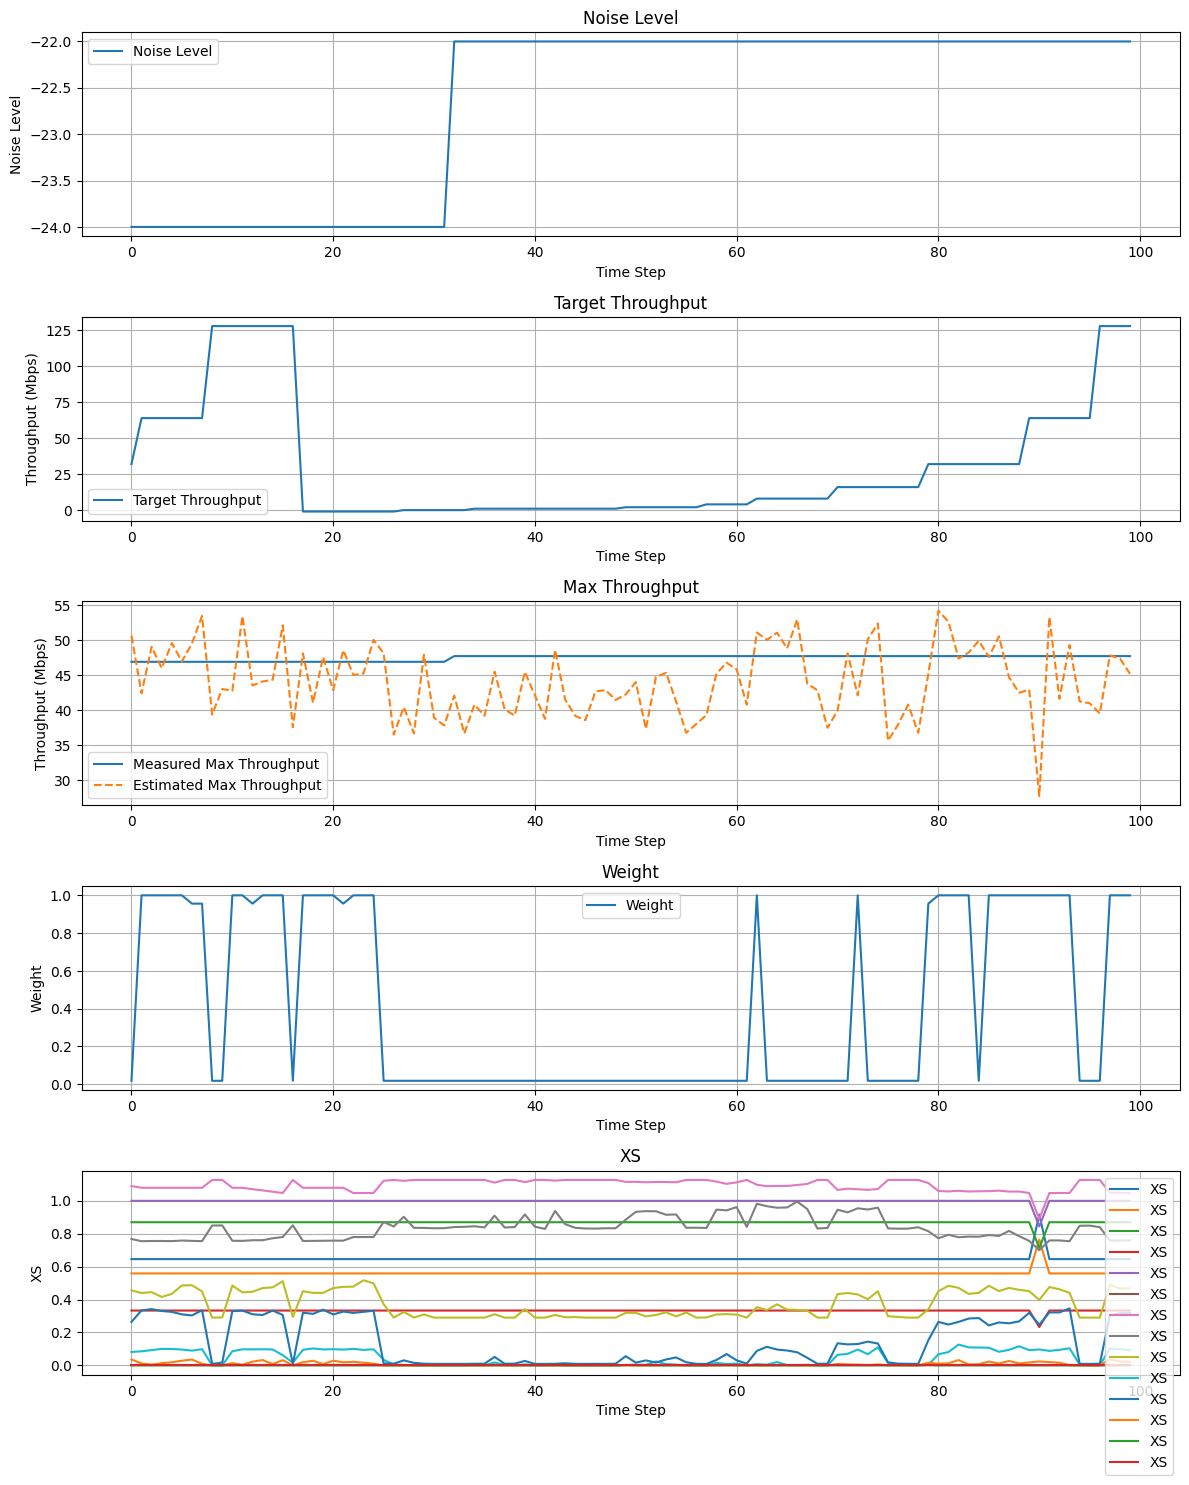

---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: t

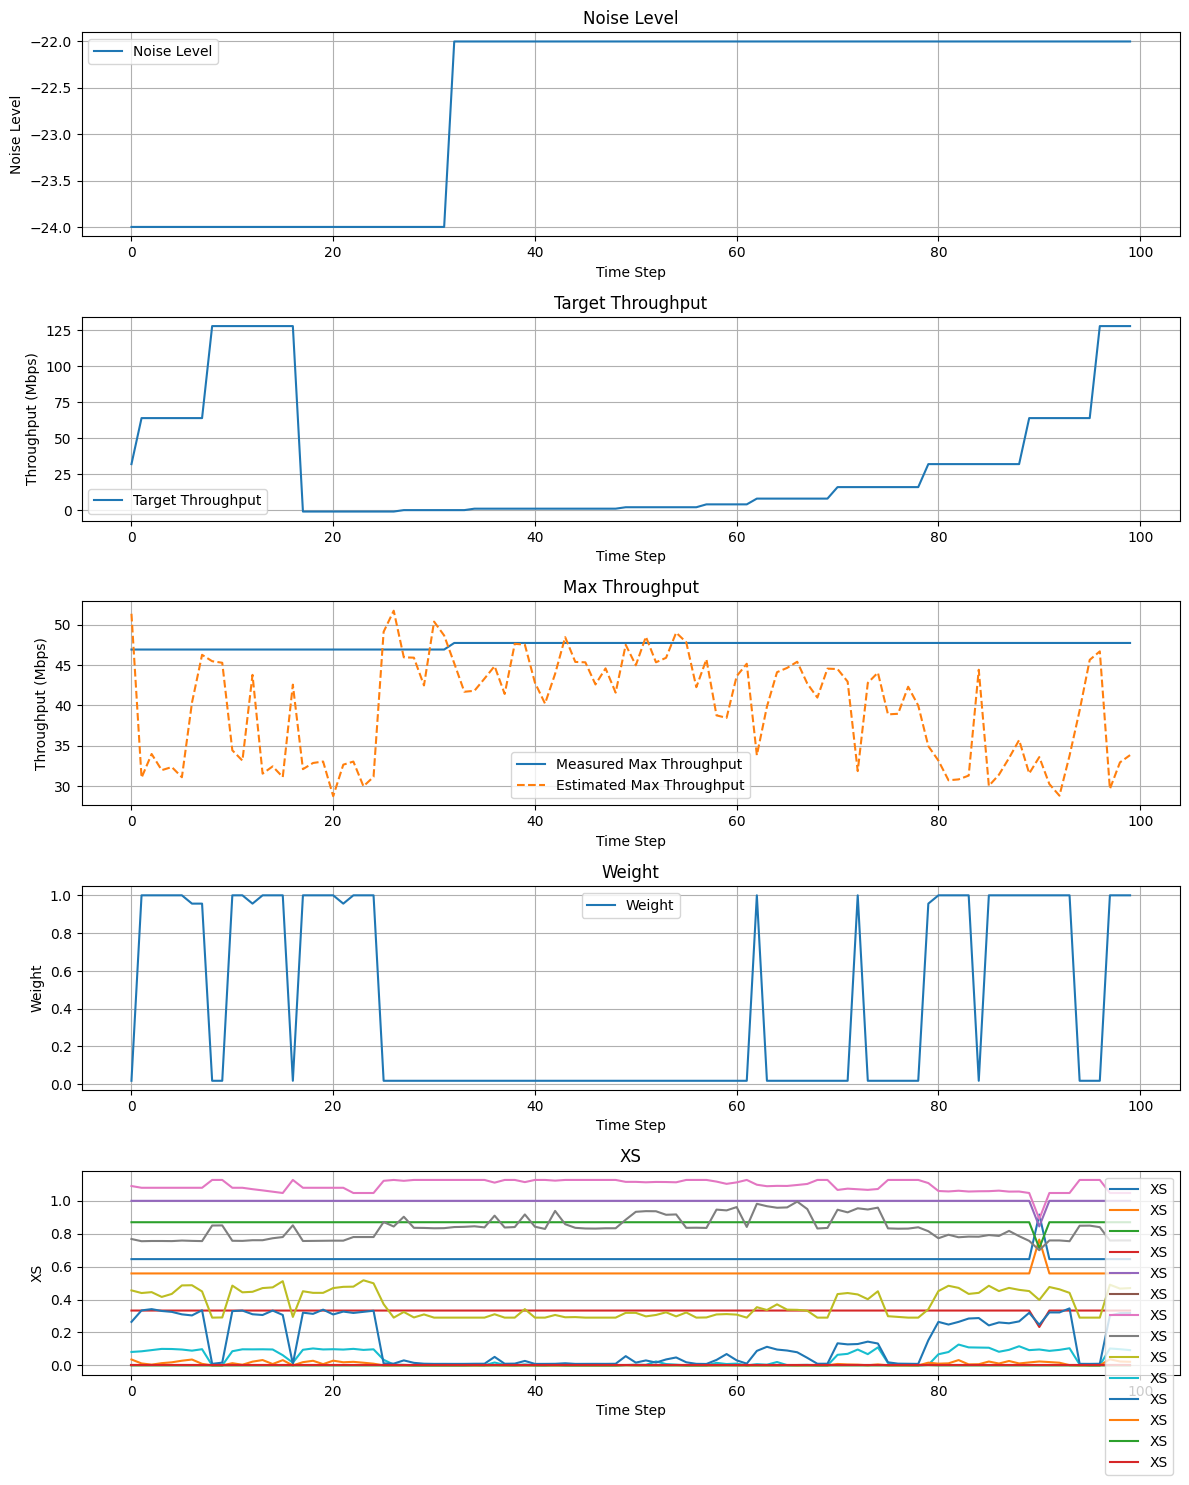

In [14]:
mac_iq_model.show_test(preloaded_test_data)
mac_model.show_test(preloaded_test_data)
iq_model.show_test(preloaded_test_data)

mac_iq_model.show_test(preloaded_test_data, step=1, start_idx=1000, stop_idx=1100)
mac_model.show_test(preloaded_test_data, step=1, start_idx=1000, stop_idx=1100)
iq_model.show_test(preloaded_test_data, step=1, start_idx=1000, stop_idx=1100)

In [16]:
mac_iq_model.save(os.path.join(PROJECT_PATH, 'throughput_estimator_model_mac_iq.pth'))
mac_model.save(os.path.join(PROJECT_PATH, 'throughput_estimator_model_mac.pth'))
iq_model.save(os.path.join(PROJECT_PATH, 'throughput_estimator_model_iq.pth'))

In [18]:
with torch.no_grad():  # Disable gradient computation
    for i, (batch_mac, batch_fapi, batch_iq, batch_y_noise_level, batch_y_target_throughput_mbps, batch_y_max_throughput_mbps) in enumerate(preloaded_test_data):
        # Move to device
        batch_mac = batch_mac.to(0)
        batch_iq = batch_iq.to(0)
        batch_fapi = batch_fapi.to(0)
        print("---")
        print(f'batch_fapi: {batch_fapi}')

        outputs, w = mac_iq_model(batch_mac, batch_fapi, batch_iq)
        print(f'w: {w}')

        predicted = outputs.cpu().numpy().squeeze()  # Handle shape
        print(predicted)
        if predicted == 0:
            print(batch_mac)

---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
46.609013
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
53.843227
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
52.71126
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
51.521404
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
47.041687
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
52.344936
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
51.638454
---
batch_fapi: tensor([[0.0000, 0.0183, 0.0000, 1.0000]], device='cuda:0')
w: tensor([[0.0183]], device='cuda:0')
48.792217
-

In [20]:
x_macs = np.stack(dataset['mac'].to_numpy())
x_fapis = np.stack(dataset['fapi'].to_numpy())
x_iqs = np.stack(dataset['iq'].to_numpy())
ys = np.stack(dataset['max_throughput_mbps'].to_numpy())
print(x_macs.shape)
print(x_iqs.shape)
print(ys.shape)

(14613, 30, 14)
(14613, 2, 3276, 14)
(14613,)


Target throughput: 49.236976686996854
predicted: 49.47519302368164
w: [[1.]]


/tmp/ipykernel_86278/3202301522.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10*np.log10(rms_array), aspect='auto')


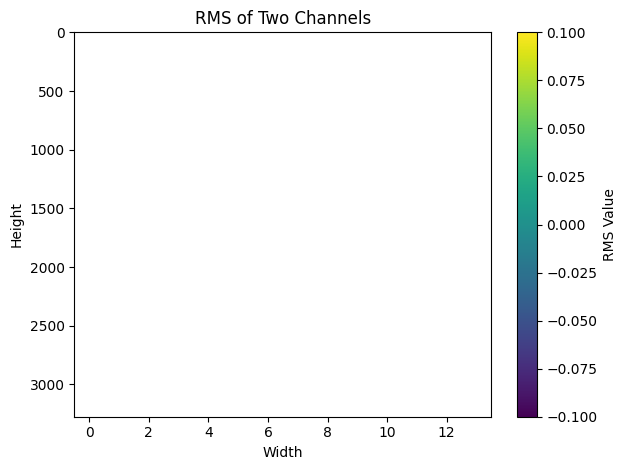

Target throughput: 54.25797151979649
predicted: 50.77328872680664
w: [[0.01831502]]


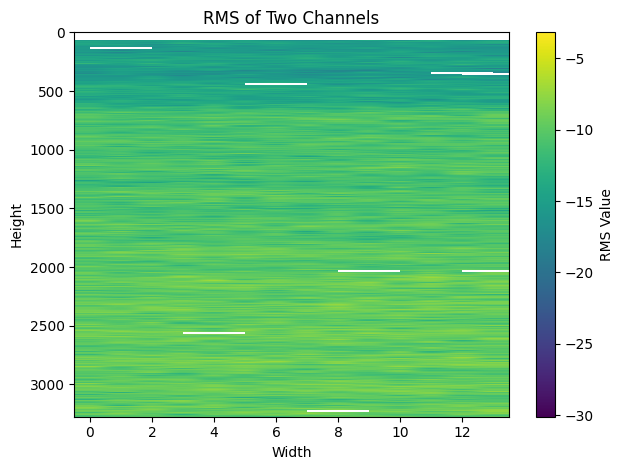

Target throughput: 50.4968827068002
predicted: 45.24480056762695
w: [[0.01831502]]


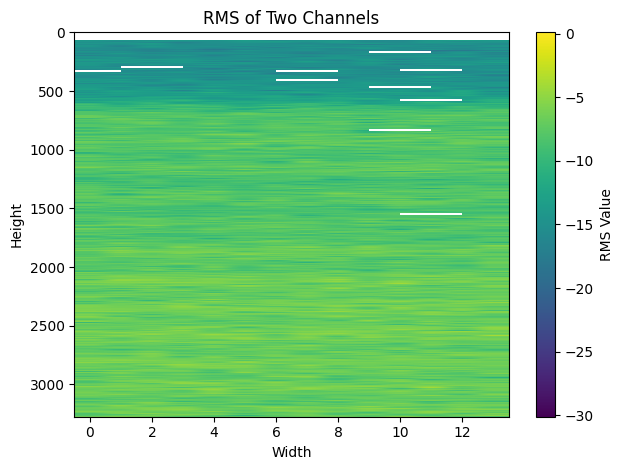

Target throughput: 46.924193592129534
predicted: 48.565162658691406
w: [[0.01831502]]


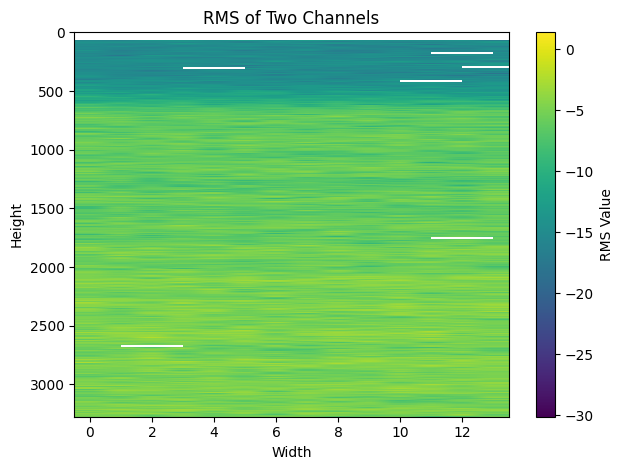

Target throughput: 41.6357896081075
predicted: 46.38200759887695
w: [[1.]]


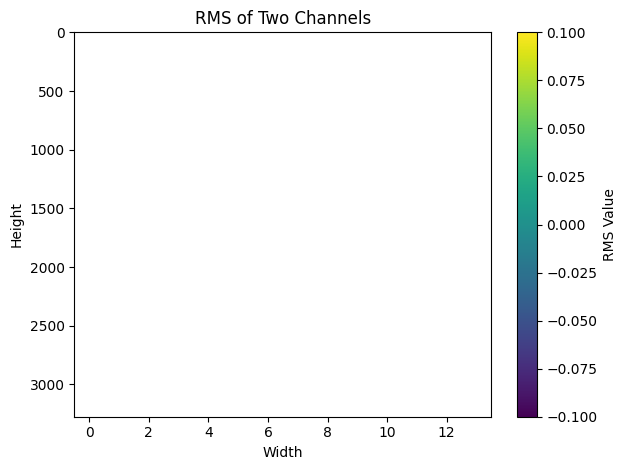

Target throughput: 31.96085651016849
predicted: 28.74424171447754
w: [[0.01831502]]


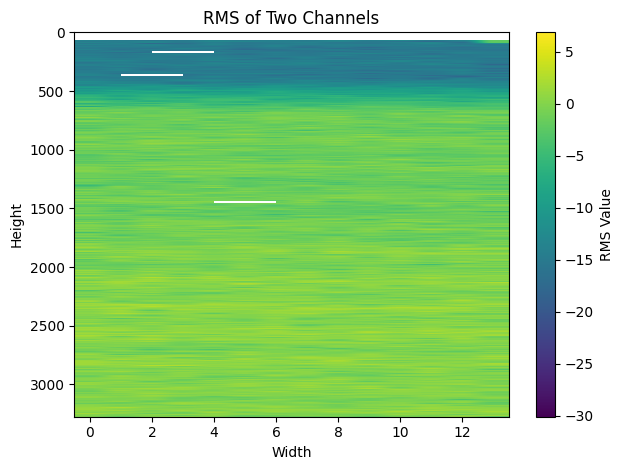

Target throughput: 28.857437247849056
predicted: 31.89553451538086
w: [[1.]]


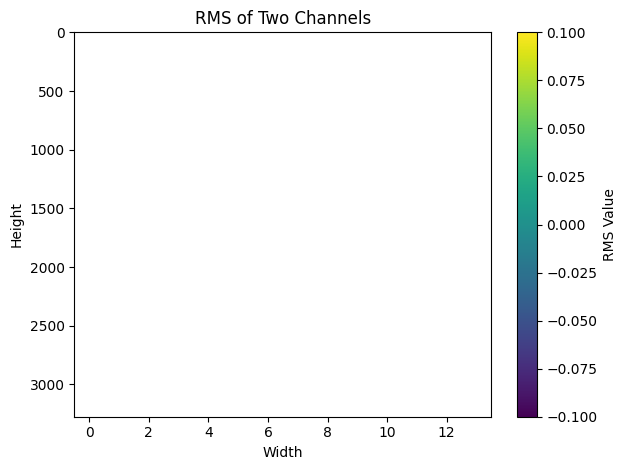

Target throughput: 26.107323745303546
predicted: 27.352251052856445
w: [[0.95604396]]


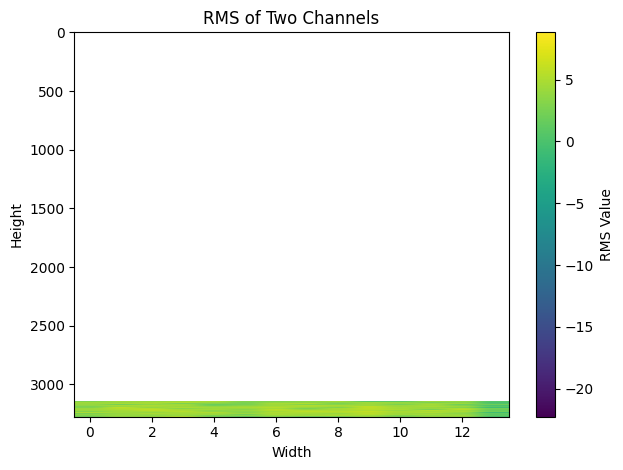

Target throughput: 26.022440365154676
predicted: 25.99298667907715
w: [[0.01831502]]


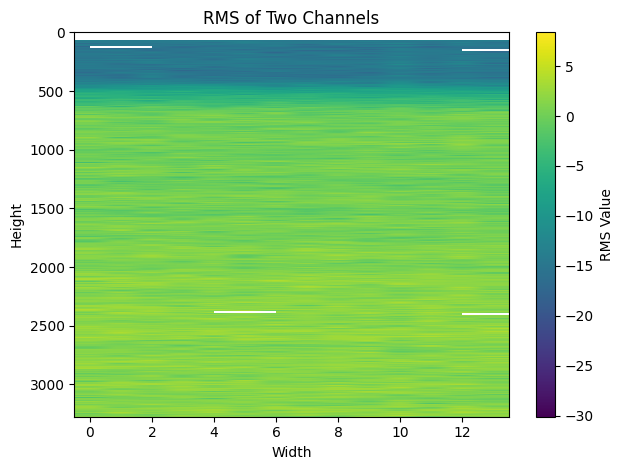

Target throughput: 27.52101596422768
predicted: 26.440710067749023
w: [[0.01831502]]


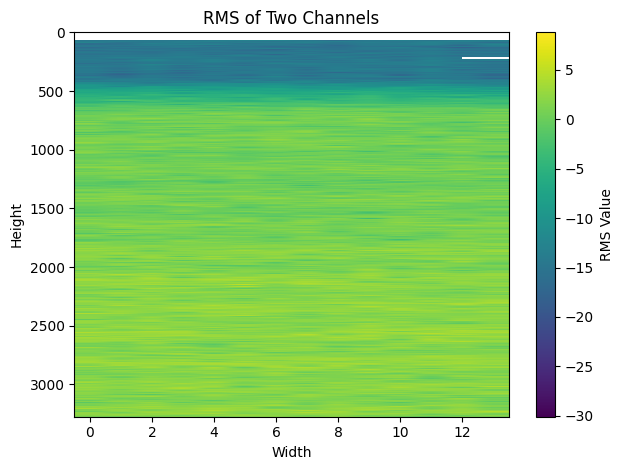

In [25]:
INDEXs = [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000]

for INDEX in INDEXs:
    x_mac = x_macs[INDEX]
    x_fapi = x_fapis[INDEX]
    x_iq = x_iqs[INDEX]
    y = ys[INDEX]
    # print(x_mac.shape)
    # print(x_fapi)
    # print(x_iq.shape)
    print(f'Target throughput: {y}')

    batch_x_mac = torch.tensor(np.array([x_mac]), dtype=torch.float32)
    batch_x_fapi = torch.tensor(np.array([x_fapi]), dtype=torch.float32)
    batch_x_iq = torch.tensor(np.array([x_iq]), dtype=torch.float32)
    
    batch_x_mac_device = batch_x_mac.to(0)
    batch_x_fapi_device = batch_x_fapi.to(0)
    batch_x_iq_device = batch_x_iq.to(0)
    
    with torch.no_grad():
        predicted, w = mac_iq_model(batch_x_mac_device, batch_x_fapi_device, batch_x_iq_device)  # LSTM uses batch_mac only
    print(f'predicted: {predicted.cpu().numpy().squeeze()}')
    print(f'w: {w.cpu().numpy()}')

    # Compute RMS across the two channels
    # RMS = sqrt(mean(x^2)) over the channel axis (axis 0)
    rms_array = np.sqrt(np.mean(x_iq ** 2, axis=0))  # Shape: (3276, 14)
    # Plot the RMS array as an image
    # plt.figure(figsize=(5, 20))  # Tall and narrow figure for 3276x14
    plt.imshow(10*np.log10(rms_array), aspect='auto')
    plt.title('RMS of Two Channels')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.colorbar(label='RMS Value')
    plt.axis('on')
    plt.tight_layout()
    plt.show()
